In [1]:
import json
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import seaborn as sns

In [2]:
# pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
# pd.set_option('display.width', )
pd.set_option('display.max_colwidth', None)

# set matplotlib style
# plt.style.use('seaborn-whitegrid')
# set font styles and size
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 12

# set seaborn style
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

# set seaborn color palette
sns.set_palette('colorblind')

In [3]:
name_map = {
    'Llama-2-7b-hf': 'Llama-2 (base)',
    # 'llama_2_7b_hf_mono_merged': 'Mono',
    'llama_2_7b_hf_ml1_merged': 'Llama-2 Mono',
    'llama_2_7b_hf_ml2_merged': 'Llama-2 Multi-2',
    'llama_2_7b_hf_ml3_merged': 'Llama-2 Multi-3',
    'llama_2_7b_hf_ml4_merged': 'Llama-2 Multi-4',
    'llama_2_7b_hf_ml5_merged': 'Llama-2 Multi-5',
    'llama_2_7b_hf_ml6_merged': 'Llama-2 Multi-6',
    # 'llama_2_7b_hf_en_merged': 'Multi-6/en',
    'llama_2_7b_hf_es_merged': 'Llama-2 Multi-6/es',
    'llama_2_7b_hf_ru_merged': 'Llama-2 Multi-6/ru',
    'llama_2_7b_hf_de_merged': 'Llama-2 Multi-6/de',
    'llama_2_7b_hf_zh_merged': 'Llama-2 Multi-6/zh',
    'llama_2_7b_hf_fr_merged': 'Llama-2 Multi-6/fr',
    'llama_2_7b_hf_ca_merged': 'Llama-2 Multi-6/ca',
    'llama_2_7b_hf_mt_es_merged': 'Llama-2 MT Multi-6/es', # translated training data
    'llama_2_7b_hf_mt_ru_merged': 'Llama-2 MT Multi-6/ru', # translated training data
    'llama_2_7b_hf_mt_de_merged': 'Llama-2 MT Multi-6/de', # translated training data
    'llama_2_7b_hf_mt_zh_merged': 'Llama-2 MT Multi-6/zh', # translated training data
    'llama_2_7b_hf_mtol_de_merged': 'Llama-2 MTOL Multi-6/de', # translated training data
    'llama_2_7b_hf_mtol_ca_merged': 'Llama-2 MTOL Multi-6/ca', # translated training data
    'llama_2_7b_hf_mt_ml2_n50_merged': 'Llama-2 MT Multi-2 N=50', # translated training data: ablation 4 (fixed ML2, NE=50)
    'llama_2_7b_hf_mt_ml2_n100_merged': 'Llama-2 MT Multi-2 N=100', # translated training data: ablation 4 (fixed ML2, NE=100)
    'llama_2_7b_hf_mt_ml2_merged': 'Llama-2 MT Multi-2', # translated training data / ablation 4 (fixed ML2, NE=200)
    'llama_2_7b_hf_mt_ml2_n300_merged': 'Llama-2 MT Multi-2 N=300', # translated training data: ablation 4 (fixed ML2, NE=300)
    'llama_2_7b_hf_mt_ml2_n400_merged': 'Llama-2 MT Multi-2 N=400', # translated training data: ablation 4 (fixed ML2, NE=400)
    'llama_2_7b_hf_mt_ml2_n1000_merged': 'Llama-2 MT Multi-2 N=1000', # translated training data: ablation 4 (fixed ML2, NE=1000)
    'llama_2_7b_hf_mt_ml3_n5_merged': 'Llama-2 MT Multi-3 N=5', # translated training data: ablation 1 (fixed ML3, NE=10)
    'llama_2_7b_hf_mt_ml3_n10_merged': 'Llama-2 MT Multi-3 N=10', # translated training data: ablation 1 (fixed ML3, NE=20)
    'llama_2_7b_hf_mt_ml3_n25_merged': 'Llama-2 MT Multi-3 N=25', # translated training data: ablation 1 (fixed ML3, NE=50)
    'llama_2_7b_hf_mt_ml3_n50_merged': 'Llama-2 MT Multi-3 N=50', # translated training data: ablation 1 (fixed ML3, NE=100)
    'llama_2_7b_hf_mt_ml3_n100_merged': 'Llama-2 MT Multi-3 N=100', # translated training data: ablation 1 (fixed ML3, NE=200)
    'llama_2_7b_hf_mt_ml3_n500_merged': 'Llama-2 MT Multi-3 N=500', # translated training data: ablation 3 (incremental ML, NE=1000)
    'llama_2_7b_hf_mt_ml3_merged': 'Llama-2 MT Multi-3', # translated training data / ablation 1 (fixed ML3, NE=400) / ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_mt_ml4_merged': 'Llama-2 MT Multi-4', # translated training data
    'llama_2_7b_hf_mt_ml4_n133_merged': 'Llama-2 MT Multi-4 N=133', # translated training data: ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_mt_ml4_n333_merged': 'Llama-2 MT Multi-4 N=333', # translated training data: ablation 3 (incremental ML, NE=1000)
    'llama_2_7b_hf_mt_ml5_merged': 'Llama-2 MT Multi-5', # translated training data
    'llama_2_7b_hf_mt_ml5_n100_merged': 'Llama-2 MT Multi-5 N=100', # translated training data: ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_mt_ml5_n250_merged': 'Llama-2 MT Multi-5 N=250', # translated training data: ablation 3 (incremental ML, NE=1000)
    'llama_2_7b_hf_mt_ml6_merged': 'Llama-2 MT Multi-6', # translated training data
    'llama_2_7b_hf_mt_ml6_n80_merged': 'Llama-2 MT Multi-6 N=80', # translated training data: ablation 2 (incremental ML, NE=400)
    'llama_2_7b_hf_guanaco_merged': 'Llama-2 Multi-Guanaco',
    'falcon_7b_ml1_merged': 'Falcon Mono',
    'falcon_7b_ml2_merged': 'Falcon Multi-2',
    'falcon_7b_ml3_merged': 'Falcon Multi-3',
    'falcon_7b_ml4_merged': 'Falcon Multi-4',
    'falcon_7b_ml5_merged': 'Falcon Multi-5',
    'falcon_7b_ml6_merged': 'Falcon Multi-6',
    'falcon_7b_es_merged': 'Falcon Multi-6/es',
    'falcon_7b_ru_merged': 'Falcon Multi-6/ru',
    'falcon_7b_de_merged': 'Falcon Multi-6/de',
    'falcon_7b_zh_merged': 'Falcon Multi-6/zh',
    'falcon_7b_fr_merged': 'Falcon Multi-6/fr',
    'falcon_7b_ca_merged': 'Falcon Multi-6/ca',
    'falcon_7b_guanaco_merged': 'Falcon Multi-Guanaco',
    'llama_2_70b_hf_mt_ml1_merged': 'Llama-2 70B Mono', 
    'llama_2_70b_hf_mt_ml2_merged': 'Llama-2 70B MT Multi-2', # translated training data
    'llama_2_70b_hf_mt_ml3_merged': 'Llama-2 70B MT Multi-3', # translated training data
    'llama_2_70b_hf_mt_ml4_merged': 'Llama-2 70B MT Multi-4', # translated training data
    'llama_2_70b_hf_mt_ml5_merged': 'Llama-2 70B MT Multi-5', # translated training data
    'llama_2_70b_hf_mt_ml6_merged': 'Llama-2 70B MT Multi-6', # translated training data
    'llama_2_70b_hf_guanaco_merged': 'Llama-2 70B Multi-Guanaco', # translated training data
    'alpaca_eval_instructions_en': 'en',
    'alpaca_eval_instructions_es': 'es',
    'alpaca_eval_instructions_ru': 'ru',
    'alpaca_eval_instructions_de': 'de',
    'alpaca_eval_instructions_zh': 'zh',
    'alpaca_eval_instructions_fr': 'fr',
    'alpaca_eval_instructions_ca': 'ca',
    'alpaca_eval_instructions_sv': 'sv',
    'alpaca_eval_instructions_bg': 'bg',
    'alpaca_eval_instructions_no': 'no',
    'alpaca_eval_instructions_da': 'da',
    'alpaca_eval_instructions_is': 'is',
    'alpaca_eval_instructions_hi': 'hi',
    'alpaca_eval_instructions_el': 'el',
    'flores_devtest_en_es': 'es',
    'flores_devtest_en_ru': 'ru',
    'flores_devtest_en_de': 'de',
    'flores_devtest_en_zh': 'zh',
    'flores_devtest_en_fr': 'fr',
    'flores_devtest_en_ca': 'ca',
    'flores_devtest_en_sv': 'sv',
    'flores_devtest_en_bg': 'bg',
    'flores_devtest_en_no': 'no',
    'flores_devtest_en_da': 'da',
    'flores_devtest_en_is': 'is',
    'flores_devtest_en_hi': 'hi',
    'flores_devtest_en_el': 'el',
    # XCSQA
    'xcsqa_dev_en_en': 'en:en',
    'xcsqa_dev_en_es': 'en:es',
    'xcsqa_dev_en_ru': 'en:ru',
    'xcsqa_dev_en_de': 'en:de',
    'xcsqa_dev_en_zh': 'en:zh',
    'xcsqa_dev_en_fr': 'en:fr',
    'xcsqa_dev_en_hi': 'en:hi',
    'xcsqa_dev_es_es': 'es:es',
    'xcsqa_dev_ru_ru': 'ru:ru',
    'xcsqa_dev_de_de': 'de:de',
    'xcsqa_dev_zh_zh': 'zh:zh',
    'xcsqa_dev_fr_fr': 'fr:fr',
    'xcsqa_dev_hi_hi': 'hi:hi',
    # XQuAD
    'xquad_dev_en_en': 'en:en',
    'xquad_dev_en_es': 'en:es',
    'xquad_dev_es_es': 'es:es',
    'xquad_dev_en_ru': 'en:ru',
    'xquad_dev_ru_ru': 'ru:ru',
    'xquad_dev_en_de': 'en:de',
    'xquad_dev_de_de': 'de:de',
    'xquad_dev_en_zh': 'en:zh',
    'xquad_dev_zh_zh': 'zh:zh',
    'xquad_dev_en_hi': 'en:hi',
    'xquad_dev_hi_hi': 'hi:hi',
    'xquad_dev_en_el': 'en:el',
    'xquad_dev_el_el': 'el:el',
    'xquad_dev_en_ar': 'en:ar',
    'xquad_dev_ar_ar': 'ar:ar', 
    'xquad_dev_en_tr': 'en:tr',
    'xquad_dev_tr_tr': 'tr:tr',
    'xquad_dev_en_vi': 'en:vi',
    'xquad_dev_vi_vi': 'vi:vi',
    'xquad_dev_en_th': 'en:th',
    'xquad_dev_th_th': 'th:th',
}

training_langs = {
    'Mono': ['en'],
    'Multi-2': ['en', 'es'],
    'Multi-3': ['en', 'es', 'ru'],
    # 'N=5': ['en', 'es', 'ru'],
    # 'N=10': ['en', 'es', 'ru'],
    # 'N=25': ['en', 'es', 'ru'],
    # 'N=50': ['en', 'es', 'ru'],
    # 'N=100': ['en', 'es', 'ru'],
    # 'N=1000': ['en', 'es'], # 1000/1 + en
    # 'N=500': ['en', 'es', 'ru'], # 1000/2 + en
    # 'N=333': ['en', 'es', 'ru', 'de'], # 1000/3 + en
    # 'N=250': ['en', 'es', 'ru', 'de', 'zh'], # 1000/4 + en
    'Multi-4': ['en', 'es', 'ru', 'de'],
    'Multi-5': ['en', 'es', 'ru', 'de', 'zh'],
    'Multi-6': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'Multi-6/de': ['en', 'es', 'ru', 'zh', 'fr', 'ca'],
    'Multi-6/fr': ['en', 'es', 'ru', 'de', 'zh', 'ca'],
    'Multi-6/zh': ['en', 'es', 'ru', 'de', 'fr', 'ca'],
    'Multi-6/es': ['en', 'ru', 'de', 'zh', 'fr', 'ca'],
    'Multi-6/ru': ['en', 'es', 'de', 'zh', 'fr', 'ca'],
    'Multi-6/ca': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'Multi-Guanaco': ['es', 'en', 'ru', 'de', 'zh', 'fr', 'ca', 'th', 'pt', 'it', 'uk', 'eu', 'jp', 'pl', 'zh', 'vi', 'hu', 'gn', 'da', 'tr', 'nl', 'gl', 'mt', 'ar', 'ms', 'sc', 'nn', 'ko', 'ht', 'ar', 'id', 'ar', 'wo', 'uz', 'lv', 'jv', 'fi', 'tk', 'tg', 'sv', 'so', 'sl', 'sk', 'no', 'kk', 'ga', 'cz'],
}

def load_json(file):
    with open(file, "r", encoding='utf8') as f:
        return json.load(f)

def parse_filename(file):
    """
    data/outputs/llama_2_7b_hf_en_merged/alpaca_eval_instructions_ru-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.eval
    """
    # get test set and context, allowing for no context
    model_name = Path(file).parent.name
    parts = Path(file).stem.split('-')

    test_set = parts[0]
    context = parts[1]
    prompt = parts[2]
    seed = int(parts[3][1:])
    top_k = int(parts[4][1:])
    top_p = float(parts[5][1:])
    temp = float(parts[6][1:])
    bs = int(parts[7][1:])

    has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = None, None, None, None, None, None
    if len(parts) > 8:

        # with_en-l300-ds42-as42-source_en-system_en
        has_translation = parts[8] == 'with_en'
        n_eval_items = int(parts[-5][1:])
        data_seed = int(parts[-4][2:])
        api_seed = int(parts[-3][2:])
        eval_src = parts[-2]
        eval_tgt = parts[-1]

    return model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt

# sort models given the order in name_map
ordered_model_names = [v for k, v in name_map.items() if k.lower().startswith('llama') or k.lower().startswith('falcon')]
print(ordered_model_names)
ordered_alpaca_test_sets = [v for k, v in name_map.items() if k.startswith('alpaca')]
print(ordered_alpaca_test_sets)
ordered_flores_test_sets = [v for k, v in name_map.items() if k.startswith('flores')]
print(ordered_flores_test_sets)
ordered_xcsr_test_sets = [v for k, v in name_map.items() if k.startswith('xcsqa')]
print(ordered_xcsr_test_sets)
ordered_xquad_test_sets = [v for k, v in name_map.items() if k.startswith('xquad')]
print(ordered_xquad_test_sets)

def apply_sort(df, ordered_test_sets, ordered_model_names=ordered_model_names):

    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df['test_set'] = pd.Categorical(df['test_set'], ordered_test_sets)

    if 'seed' in df.columns:
        df = df.sort_values(by=['model_name', 'test_set', 'seed'])
    else:
        df = df.sort_values(by=['model_name', 'test_set'])

    # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    df['test_set'] = df['test_set'].astype(str)
        
    df = df.reset_index(drop=True)

    df.info()
    
    return df

['Llama-2 (base)', 'Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 'Llama-2 Multi-6/es', 'Llama-2 Multi-6/ru', 'Llama-2 Multi-6/de', 'Llama-2 Multi-6/zh', 'Llama-2 Multi-6/fr', 'Llama-2 Multi-6/ca', 'Llama-2 MT Multi-6/es', 'Llama-2 MT Multi-6/ru', 'Llama-2 MT Multi-6/de', 'Llama-2 MT Multi-6/zh', 'Llama-2 MTOL Multi-6/de', 'Llama-2 MTOL Multi-6/ca', 'Llama-2 MT Multi-2 N=50', 'Llama-2 MT Multi-2 N=100', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-2 N=300', 'Llama-2 MT Multi-2 N=400', 'Llama-2 MT Multi-2 N=1000', 'Llama-2 MT Multi-3 N=5', 'Llama-2 MT Multi-3 N=10', 'Llama-2 MT Multi-3 N=25', 'Llama-2 MT Multi-3 N=50', 'Llama-2 MT Multi-3 N=100', 'Llama-2 MT Multi-3 N=500', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-4 N=133', 'Llama-2 MT Multi-4 N=333', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-5 N=100', 'Llama-2 MT Multi-5 N=250', 'Llama-2 MT Multi-6', 'Llama-2 MT Multi-6 N=80', 'Llama-2 Multi-Guanaco', 'Falcon

In [5]:

def get_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for eval_file in Path(results_dir).glob('*/*.eval'):
        # print(eval_file)
        df = pd.read_csv(eval_file, index_col=None)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(eval_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
        # # get generation args too
        # try:
        #     hp_file = eval_file.with_suffix(".json")
        #     hps = load_json(hp_file)
        #     eval_dict.update(hps)
        # except:
        #     pass
    
    df = pd.concat(dfs, axis=0, ignore_index=True)

    df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

    # add column for training languages
    df['training_langs'] = df.apply(lambda x: training_langs[x['model_name'].split()[-1]] if not 'N=' in x['model_name'] else training_langs[x['model_name'].split()[-2]], axis=1)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('training_langs')))
    df = df.reindex(columns=cols)

    df.info()
    
    return df

df = get_results('data/alpaca_eval_outputs')
print(len(df))
print(df.columns)
df = apply_sort(df, ordered_test_sets=ordered_alpaca_test_sets)
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1722 entries, 0 to 1721
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_name      1722 non-null   object 
 1   test_set        1722 non-null   object 
 2   seed            1722 non-null   int64  
 3   training_langs  1722 non-null   object 
 4   lang_match      1722 non-null   float64
 5   tgt_lang        1722 non-null   float64
 6   ppl             756 non-null    float64
 7   ppl_model       594 non-null    object 
 8   n               1602 non-null   float64
 9   file            1722 non-null   object 
 10  context         1722 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 148.1+ KB
1722
Index(['model_name', 'test_set', 'seed', 'training_langs', 'lang_match',
       'tgt_lang', 'ppl', 'ppl_model', 'n', 'file', 'context'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1722 entries, 0 to 1721
Data c

,model_name,test_set,seed,training_langs,lang_match,tgt_lang,ppl,ppl_model,n,file,context
0,Llama-2 Mono,en,0,[en],0.944,0.964,14.927,NaN,NaN,data/alpaca_eval_outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt
1,Llama-2 Mono,en,42,[en],0.933,0.954,20673.208,NaN,NaN,data/alpaca_eval_outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt
2,Llama-2 Mono,en,723,[en],0.938,0.960,18.525,NaN,NaN,data/alpaca_eval_outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s723-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt
3,Llama-2 Mono,es,0,[en],0.436,0.450,20.300,ai-forever/mGPT,805.0,data/alpaca_eval_outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_es-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt
4,Llama-2 Mono,es,42,[en],0.451,0.467,43.756,ai-forever/mGPT,805.0,data/alpaca_eval_outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_es-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt


In [6]:
df['model_name'].unique()

array(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3',
       'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6',
       'Llama-2 MT Multi-2 N=50', 'Llama-2 MT Multi-2 N=100',
       'Llama-2 MT Multi-2', 'Llama-2 MT Multi-2 N=300',
       'Llama-2 MT Multi-2 N=400', 'Llama-2 MT Multi-2 N=1000',
       'Llama-2 MT Multi-3 N=5', 'Llama-2 MT Multi-3 N=10',
       'Llama-2 MT Multi-3 N=25', 'Llama-2 MT Multi-3 N=50',
       'Llama-2 MT Multi-3 N=100', 'Llama-2 MT Multi-3 N=500',
       'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4',
       'Llama-2 MT Multi-4 N=133', 'Llama-2 MT Multi-4 N=333',
       'Llama-2 MT Multi-5', 'Llama-2 MT Multi-5 N=100',
       'Llama-2 MT Multi-6', 'Llama-2 MT Multi-6 N=80',
       'Llama-2 Multi-Guanaco', 'Falcon Mono', 'Falcon Multi-2',
       'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5',
       'Falcon Multi-6', 'Falcon Multi-Guanaco', 'Llama-2 70B Mono',
       'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3',
       'Llama-2 70B MT Mult

In [7]:
def get_results_overview(df, cols=['model_name', 'test_set', 'seed']):
    for col in cols:
        print(f'*** {col} ***')
        print(df[col].value_counts())
        print()

get_results_overview(df)

*** model_name ***
Llama-2 Mono                 42
Llama-2 MT Multi-4 N=333     42
Llama-2 MT Multi-5 N=100     42
Llama-2 MT Multi-6           42
Llama-2 MT Multi-6 N=80      42
Llama-2 Multi-Guanaco        42
Falcon Mono                  42
Falcon Multi-2               42
Falcon Multi-3               42
Falcon Multi-4               42
Falcon Multi-5               42
Falcon Multi-6               42
Falcon Multi-Guanaco         42
Llama-2 70B Mono             42
Llama-2 70B MT Multi-2       42
Llama-2 70B MT Multi-3       42
Llama-2 70B MT Multi-4       42
Llama-2 70B MT Multi-5       42
Llama-2 70B MT Multi-6       42
Llama-2 MT Multi-5           42
Llama-2 MT Multi-4 N=133     42
Llama-2 Multi-2              42
Llama-2 MT Multi-4           42
Llama-2 Multi-3              42
Llama-2 Multi-4              42
Llama-2 Multi-5              42
Llama-2 Multi-6              42
Llama-2 MT Multi-2 N=50      42
Llama-2 MT Multi-2 N=100     42
Llama-2 MT Multi-2           42
Llama-2 MT Multi-2 N=

In [8]:
def get_agg_df(
        df, 
        group_cols=['model_name', 'test_set'], 
        agg_ops={
            'lang_match': [np.mean, np.std], 
            'tgt_lang': [np.mean, np.std], 
            'ppl': [np.mean, np.std],
            }
        ):
    """
    Aggregates the results of the different strategies.
    If use_macro is True, then the macro-averaged results are used, otherwise the micro-averaged results are used.
    """
    df = df.groupby(group_cols, as_index=True).agg(agg_ops)
    # df = df.reindex(['0-shot', '1-shot', 'Mem-4', 'Mem-8', 'L2M'])
    # df[df.select_dtypes(include=['number']).columns] *= 100
    df = df.round(2)
    return df

def styled_df(df, color):
    return df.style.background_gradient(axis=0, text_color_threshold=0, cmap=sns.light_palette(color, as_cmap=True)).highlight_max(axis=0, props='font-weight:bold;').format(precision=2)

# unset multi-index
# agg_df = get_agg_df(df).reset_index()
# join levels of multi-index columns
# agg_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in agg_df.columns]
# styled_df(agg_df, 'seagreen')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.984313725490196, 0.6862745098039216, 0.8941176470588236)]
bar info {<matplotlib.patches.Rectangle object at 0x7f70591f41f0>: {'test_set': 'en', 'model_name': 'Mono'}, <matplotlib.patches.Rectangle object at 0x7f70591f5de0>: {'test_set': 'en', 'model_name': 'Multi-Guanaco'}, <matplotlib.patches.Rectangle object at 0x7f70591f5d20>: {'test_set': 'de', 'model_name': 'Mono'}, <matplotlib.patches.Rectangle object at 0x7f70591f61a0>: {'test_set': 'de', 'model_name': 'Multi-Guanaco'}, <matplotlib.patches.Rectangle object at 0x7f70591f4fd0>: {'test_set': 'bg', 'model_name': 'Mono'}, <matplotlib.patches.Rectangle object at 0x7f7059228a00>: {'test_set': 'bg', 'model_name': 'Multi-Guanaco'}, <matplotlib.patches.Rectangle object at 0x7f70591f42e0>: {'test_set': 'is', 'model_name': 'Mono'}, <matplotlib.patches.Rectangle object at 0x7f7059229330>: {'test_set': 'is', 'model_name': 'Multi-Guanaco'}}
Rectangle(xy=(-0.4, 0), width=0.4, h

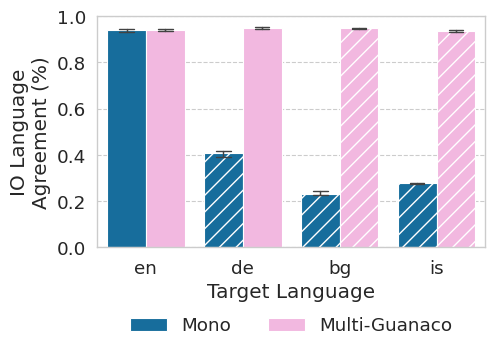

In [9]:
def make_basic_barplot_wide(df, title=None, save_path=None, make_transparent=[]):
    
    # Get the unique values for 'test_set' and 'model_name'
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()

    # number of bars to plot with hue
    expected_num_bars = len(test_sets) * len(model_names)

    width = len(test_sets)
    if len(test_sets) < 6:
        width += 1

    fig, ax = plt.subplots(figsize=(width, 3))

    # get the colors used for mono (0) and guanaco (6)
    colors = [sns.color_palette()[0], sns.color_palette()[6]]
    print(colors)

    sns.barplot(data=df,
                x='test_set', y='lang_match', 
                hue='model_name', 
                errorbar=("ci", 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                palette=colors,
                ax=ax)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    # get error bars
    errorbars = ax.lines

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    sorted_errorbars = sorted(errorbars, key=lambda bar: bar.get_xdata()[0], reverse=False)

    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    print('bar info', bar_info)
    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        print(bar, info['test_set'])
        if info['test_set'] not in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')
        
        # custom visualisation for presentation:
        
        # show only the first bar
        # if i > 0: 
        #     bar.set_alpha(0.0)
        #     errorbars[i].set_alpha(0.0)
        
        # show only the en mono bars
        # if i % 2 != 0: 
        #     print(i, bar, info['test_set'])
        #     bar.set_alpha(0.0)
        #     sorted_errorbars[i].set_alpha(0.0)            
            
    if title:
        ax.set_title(title)

    ax.set_xlabel('Target Language')
    ax.set_ylabel('IO Language\nAgreement (%)')

    # add horizontal gridlines
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.4)
    ax.set_ylim(0, 1.0)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.45
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

# plot Llama-2 models with incremental multilingual training
sdf = df[df['model_name'].isin([
    'Llama-2 Mono', 
    # 'Llama-2 Multi-6/ca', 
    'Llama-2 Multi-Guanaco'
    ])]
sdf = sdf[sdf['test_set'].isin(['en', 'de', 'bg', 'is'])]

# sdf = sdf[sdf['test_set'].isin(['sv', 'da', 'no', 'bg', 'is', 'hi', 'el'])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')

make_basic_barplot_wide(
    sdf, 
    # save_path='data/plots/chat_lang_match_llama2_7b_mono_vs_guanaco.png'
    )



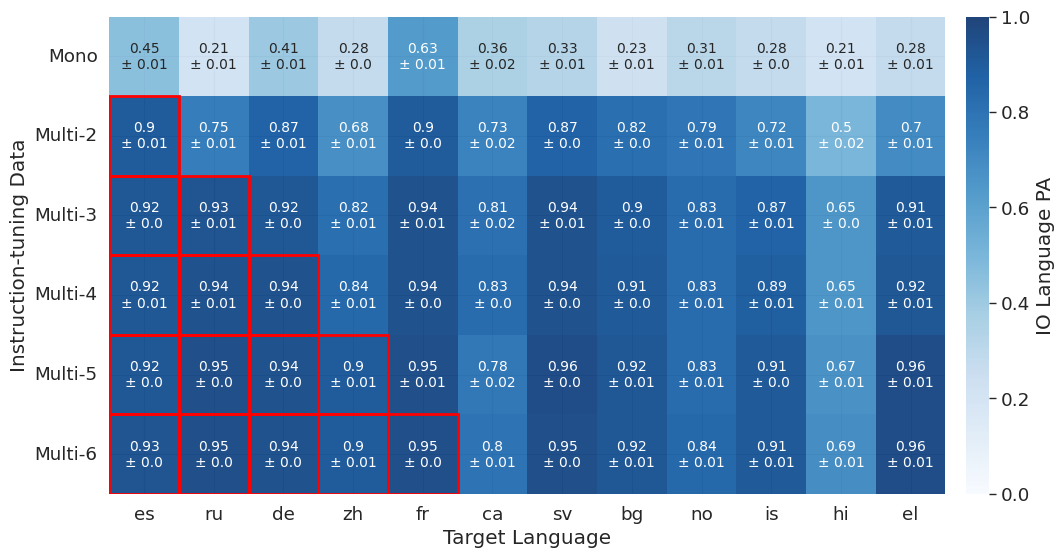

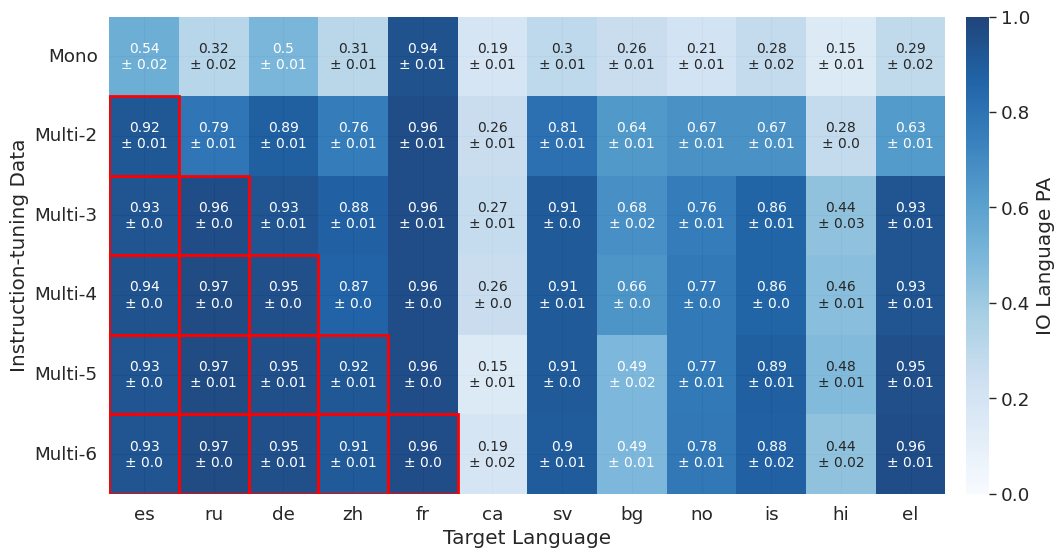

In [10]:
from matplotlib.patches import Rectangle

def make_basic_heatmap(df, metric, include_std=False, title=None, save_path=None, strip_from_model_name=None, include_hatches=False):
        
    models = df['model_name'].unique()
    test_sets = df['test_set'].unique()

    # fig, ax = plt.subplots(figsize=(df.shape[0]*0.2, df.shape[1]*0.8))
    fig, ax = plt.subplots(figsize=(len(test_sets)+1, len(models)+0.2))
    
    heatmap_mean = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_mean', sort=False)
    heatmap_std = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_std', sort=False)

    # sort by order in name_map
    heatmap_mean = heatmap_mean.reindex([n for n in ordered_model_names if n in heatmap_mean.index])
    heatmap_std = heatmap_std.reindex([n for n in ordered_model_names if n in heatmap_std.index])

    # sort columns by order in ordered_test_sets
    heatmap_mean = heatmap_mean.reindex(columns=[l for l in ordered_alpaca_test_sets if l in heatmap_mean.columns])
    heatmap_std = heatmap_std.reindex(columns=[l for l in ordered_alpaca_test_sets if l in heatmap_std.columns])

    if strip_from_model_name is not None:
        for segment in strip_from_model_name:
            heatmap_mean.index = heatmap_mean.index.str.replace(segment, '')
            heatmap_std.index = heatmap_std.index.str.replace(segment, '')

    if include_std:
        annotations = heatmap_mean.round(2).astype(str) + "\n± " + heatmap_std.round(2).astype(str)
    else:
        annotations = heatmap_std.round(2).astype(str)

    ax = sns.heatmap(
        heatmap_mean, annot=annotations, fmt='', 
        cmap='Blues', alpha=0.9, cbar=True, 
        cbar_kws={'label': f'IO Language PA', 
                #   'orientation': 'horizontal', 
                  'pad': 0.02,
                  }, 
        vmin=0, vmax=1.0, ax=ax
        )


    highlight_color = 'red'
    if include_hatches:
        # Get the x and y axis labels
        x_labels = heatmap_mean.columns.values
        y_labels = heatmap_mean.index.values

        # Iterate over the cells based on some condition
        for y in range(heatmap_mean.shape[0]):  # for each row
            for x in range(heatmap_mean.shape[1]):  # for each column
                # Check if the cell meets your condition to have hatches
                # Replace 'your_condition' with the actual condition
                if x_labels[x].strip('*') in training_langs[y_labels[y].split()[-1]]:
                    # Add a rectangle with the desired hatch pattern
                    # ax.add_patch(Rectangle((x, y), 1, 1, fill=False, hatch='O.', snap=False))
                    ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor=highlight_color, lw=2))

        
    # reduce font size of annotations
    for t in ax.texts:
        t.set_fontsize(10)
    
    if title:
        ax.set_title(title)

    ax.set_ylabel('Instruction-tuning Data')
    ax.set_xlabel('Target Language')

    # ensure yaxis labels are horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv', 'no', 'bg', 'is', 'hi', 'el'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    # save_path='data/plots/chat_lang_match_heatmap_llama2_7b_incremental.png',
    strip_from_model_name=['Llama-2 '],
    include_hatches=True
    )


sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv', 'no', 'bg', 'is', 'hi', 'el'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    # save_path='data/plots/chat_lang_match_heatmap_falcon_incremental.png',
    strip_from_model_name=['Falcon '],
    include_hatches=True
    )

# LLM Judge Results

In [11]:
def get_llm_judge_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for llm_eval_file in sorted(Path(results_dir).glob('*/*/*.jsonl')):
        # print(llm_eval_file)
        df = pd.read_json(llm_eval_file, lines=True)

        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(llm_eval_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        df['n_eval_items'] = n_eval_items
        df['data_seed'] = data_seed
        df['api_seed'] = api_seed
        df['eval_src'] = eval_src
        df['eval_tgt'] = eval_tgt
        df['eval_model'] = llm_eval_file.parent.parent.name

        dfs.append(df)
            
    print(f'Gathered {len(dfs)} dataframes.')
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('eval_src')))
    cols.insert(4, cols.pop(cols.index('eval_tgt')))
    print(cols)
    df = df.reindex(columns=cols)

    return df

df = get_llm_judge_results('data/llm_judge/likert')
print(len(df))

# inspect rows with NaN values in eval_score
# df[df['eval_score'].isna()]
# df[df['eval_score'] == 0]

# drop rows containing isna values in eval_score
df = df.dropna(subset=['eval_score'])
print(len(df))

# drop rows where eval_score is not between 1 and 6
df = df[(df['eval_score'] >= 1) & (df['eval_score'] <= 6)]
print(len(df))

# if 'system_lang' does not match 'source_lang', then set 'eval_score' to 1
df.loc[df['system_lang'] != df['source_lang'], 'eval_score'] = 1

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

# discard column with name "eval_Should I leave him. How do I like it?" - occurs once due to parsing errors from jsonl object returned from llm
# data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_el-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8-with_en-l300-ds42-as42-source_en-system_en.jsonl
df = df.drop(columns=['eval_Should I leave him. How do I like it?'])

df = apply_sort(df, ordered_test_sets=ordered_alpaca_test_sets)

# inspect total tokens from eval_meta
eval_costs = []
for i, row in df.iterrows():
    # eval_tokens.append(row['eval_meta']['prompt_tokens'] + row['eval_meta']['completion_tokens'])
    cost = row['eval_meta']['cost']
    if isinstance(row['translation_meta'], dict):
        cost += row['translation_meta']['cost']
    eval_costs.append(cost)

print(len(df))
print(len(eval_costs))
print(np.mean(eval_costs))
print(max(eval_costs))
print(min(eval_costs))
print(sum(eval_costs))

# drop columns: eval_meta, translation_meta, prompt, source, system
df = df.drop(columns=['eval_meta', 'translation_meta', 'prompt', 'source', 'system', 'source_en', 'system_en'])
len(df)

# check that for each model, the same ids are evaluated
all_ids = set()
for model_name in df['model_name'].unique():
    ids = df[df['model_name'] == model_name]['id'].unique()
    all_ids.update(ids)
print(len(all_ids))

df.info()

Gathered 1214 dataframes.
['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt', 'prompt', 'system', 'finish_reason', 'source', 'secs', 'id', 'eval_reasoning', 'eval_score', 'eval_meta', 'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed', 'api_seed', 'eval_model', 'eval_Pizzeria,', 'source_en', 'system_en', 'translation_meta', 'eval_Should I leave him. How do I like it?']
364200
364089
363781
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363781 entries, 0 to 363780
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   model_name        363781 non-null  object 
 1   test_set          363781 non-null  object 
 2   seed              363781 non-null  int64  
 3   eval_src          363781 non-null  object 
 4   eval_tgt          363781 non-null  object 
 5   prompt            363781 non-null  object 
 6   system            363781 non-null  object 
 7   finish_reason     363781 non-null 

In [12]:
print(df['model_name'].value_counts())
print(df['eval_src'].value_counts())
print(df['eval_tgt'].value_counts())
print(df['eval_score'].value_counts())
print(df['test_set'].value_counts())
print(df['id'].value_counts())
print(df['eval_model'].value_counts())

Llama-2 Multi-6              23969
Llama-2 Multi-Guanaco        11697
Falcon Multi-Guanaco         11696
Llama-2 Multi-5              11694
Falcon Multi-6               11692
Llama-2 MT Multi-6           11691
Llama-2 MT Multi-3           11690
Falcon Multi-5               11690
Falcon Mono                  11689
Llama-2 MT Multi-5           11689
Llama-2 MT Multi-2           11689
Llama-2 Multi-2              11688
Llama-2 Mono                 11688
Llama-2 70B Mono             11688
Llama-2 Multi-3              11687
Llama-2 70B MT Multi-3       11685
Llama-2 70B MT Multi-4       11685
Llama-2 Multi-4              11685
Llama-2 70B MT Multi-5       11684
Llama-2 MT Multi-4           11684
Falcon Multi-2               11684
Falcon Multi-3               11682
Falcon Multi-4               11679
Llama-2 70B MT Multi-2       11676
Llama-2 70B MT Multi-6       11674
Llama-2 70B Multi-Guanaco     9891
Llama-2 MT Multi-3 N=10       4497
Llama-2 MT Multi-3 N=50       4496
Llama-2 MT Multi-3 N

In [13]:
df.head()

,model_name,test_set,seed,eval_src,eval_tgt,finish_reason,secs,id,eval_reasoning,eval_score,source_lang,system_lang,context,n_eval_items,data_seed,api_seed,eval_model,"eval_Pizzeria,"
0,Llama-2 Mono,en,0,source,system,stop,0.793132,192,"The submission provides a clear and complete answer to the question by explaining the relationship between warmth and sleepiness through the body's internal temperature regulation. It discusses the release of chemicals such as histamine and serotonin, which cause drowsiness and fatigue, and explains the body's thermoregulatory system. Additionally, it acknowledges individual sleep needs and environmental factors that can affect sleep quality. The response lacks explicit headings, bullet points, or numbered lists to break up the information and make it easier to read, but it is logically organized and easy to follow. Therefore, it meets the '5' rating for being very helpful.",5.0,eng_Latn,eng_Latn,guanaco_prompt,300,42,42,gpt-3.5-turbo-1106,NaN
1,Llama-2 Mono,en,0,source,system,stop,1.108659,718,"The submission provides a clear and complete answer to the task by defining what 'keeping a promise' means for kids. It explains the concept in detail, highlighting how it involves small and large commitments, the development of responsibility and accountability, and the building of trust and relationships. The response is relevant, clear, and complete, meeting the requirements of the criterion.",6.0,eng_Latn,eng_Latn,guanaco_prompt,300,42,42,gpt-3.5-turbo-1106,NaN
2,Llama-2 Mono,en,0,source,system,stop,2.605155,168,"The submission provides a clear and complete answer to the question, without any additional information or explanations. It directly addresses the question and does not lack detail or explanation. However, it does not offer additional information or explanations that would be useful or insightful to the user. Therefore, it meets the criteria for 'Moderately helpful' (3).",3.0,eng_Latn,eng_Latn,guanaco_prompt,300,42,42,gpt-3.5-turbo-1106,NaN
3,Llama-2 Mono,en,0,source,system,stop,1.376305,522,"The submission is relevant to the task as it crafts a story from the given facts and scenarios. It provides a clear and complete answer, detailing the campaign, the teams' actions, and the success of the initiative. However, the response could be more concise and organized for greater clarity.",4.0,eng_Latn,eng_Latn,guanaco_prompt,300,42,42,gpt-3.5-turbo-1106,NaN
4,Llama-2 Mono,en,0,source,system,stop,0.841068,536,"The submission provides a clear and complete answer to the user's question by suggesting relevant hashtags related to the post. It offers additional information that is useful for the user's needs. However, the response lacks a structured format such as headings, bullet points, or numbered lists to break up the information and make it easier to read.",5.0,eng_Latn,eng_Latn,guanaco_prompt,300,42,42,gpt-3.5-turbo-1106,NaN


In [14]:
# set pandas settings to display more rows
pd.set_option('display.max_rows', 50)
df['model_name'].value_counts()

Llama-2 Multi-6              23969
Llama-2 Multi-Guanaco        11697
Falcon Multi-Guanaco         11696
Llama-2 Multi-5              11694
Falcon Multi-6               11692
Llama-2 MT Multi-6           11691
Llama-2 MT Multi-3           11690
Falcon Multi-5               11690
Falcon Mono                  11689
Llama-2 MT Multi-5           11689
Llama-2 MT Multi-2           11689
Llama-2 Multi-2              11688
Llama-2 Mono                 11688
Llama-2 70B Mono             11688
Llama-2 Multi-3              11687
Llama-2 70B MT Multi-3       11685
Llama-2 70B MT Multi-4       11685
Llama-2 Multi-4              11685
Llama-2 70B MT Multi-5       11684
Llama-2 MT Multi-4           11684
Falcon Multi-2               11684
Falcon Multi-3               11682
Falcon Multi-4               11679
Llama-2 70B MT Multi-2       11676
Llama-2 70B MT Multi-6       11674
Llama-2 70B Multi-Guanaco     9891
Llama-2 MT Multi-3 N=10       4497
Llama-2 MT Multi-3 N=50       4496
Llama-2 MT Multi-3 N

In [15]:

def plot_llm_judge_score_distribution(df, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    # if presentation:
    #     fig, ax = plt.subplots(figsize=(15, 5))
    # else:
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(model_names)
    # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), capsize=0.3,
                # errorbar='sd', capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
        
    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]
    errorbars = ax.lines

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    sorted_errorbars = sorted(errorbars, key=lambda bar: bar.get_xdata()[0], reverse=False)

    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
            # The index of the bar in the patches list
            index = i * len(model_names) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] not in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')

        # # custom visualisation for presentation:
        # # show only bars for en
        # if info['test_set'] not in ['en', 'de', 'zh', 'bg']:
        #     bar.set_alpha(0.0)
        #     sorted_errorbars[i].set_alpha(0.0)
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness Score')
    
    # fix ylim to 1-6
    ax.set_ylim(0.5, 4.5)

    ax.set_title(title)

    # legend at bottom
    ncols = len(model_names)
    y_offset = -0.45
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return


['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']


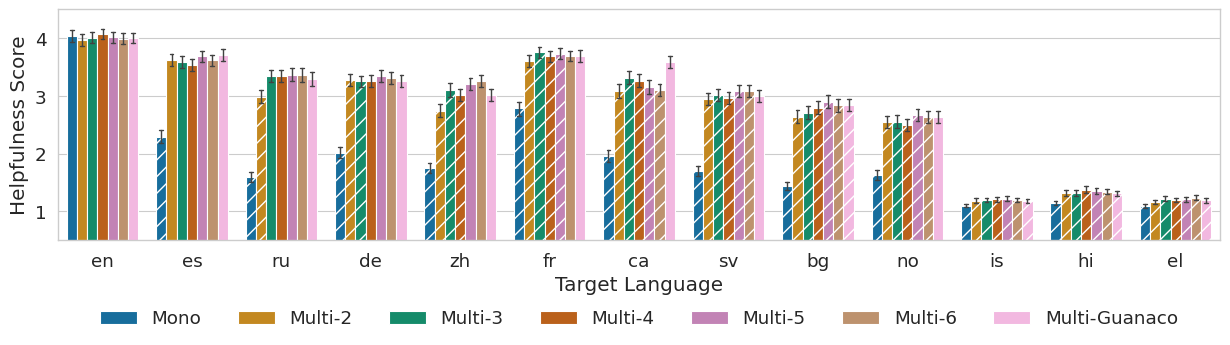

In [16]:
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 'Llama-2 Multi-Guanaco']))]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# drop bg, no, is, hi, el
# sdf = sdf[sdf['test_set'].isin(['en', 'de', 'zh', 'bg', 'is'])]

sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

plot_llm_judge_score_distribution(
    sdf, 
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental.png',
    )


MT Multi-6    11691
MT Multi-3    11690
MT Multi-2    11689
MT Multi-5    11689
Mono          11688
MT Multi-4    11684
Name: model_name, dtype: int64
['Mono' 'MT Multi-2' 'MT Multi-3' 'MT Multi-4' 'MT Multi-5' 'MT Multi-6']


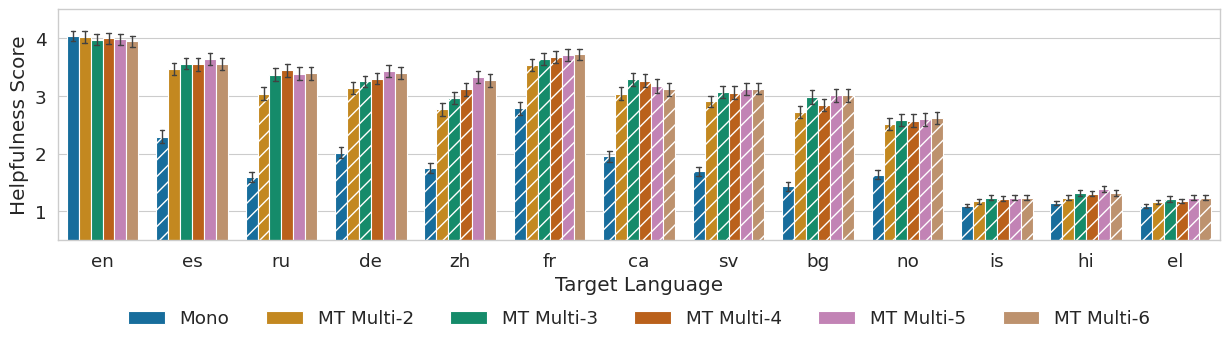

In [17]:
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-6']))]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.strip()
# print(len(sdf))
print(sdf['model_name'].value_counts())
plot_llm_judge_score_distribution(
    sdf, 
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_mt.png'
    )


Mono          11688
MT Multi-3    11685
MT Multi-4    11685
MT Multi-5    11684
MT Multi-2    11676
MT Multi-6    11674
Name: model_name, dtype: int64
['Mono' 'MT Multi-2' 'MT Multi-3' 'MT Multi-4' 'MT Multi-5' 'MT Multi-6']


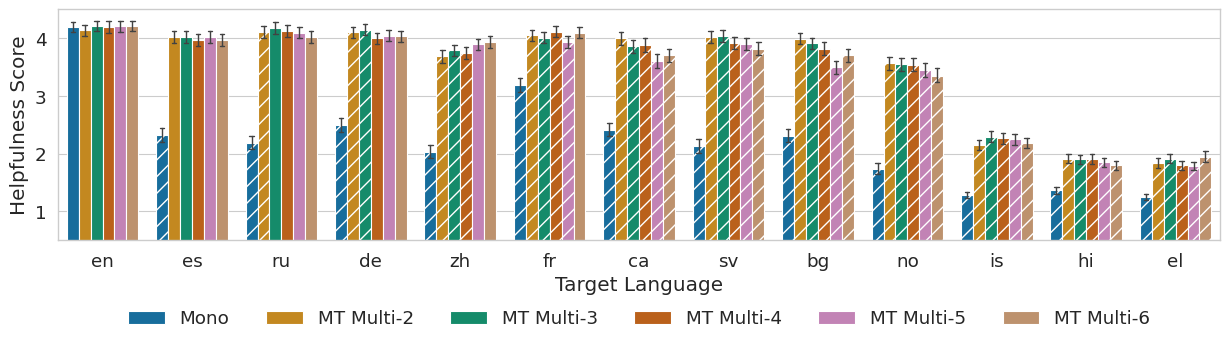

In [18]:
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6']))]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]

sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 70B', '').replace('MT', '').str.strip()
# print(len(sdf))
print(sdf['model_name'].value_counts())
plot_llm_judge_score_distribution(
    sdf, 
    # save_path='data/plots/chat_llm_judge_llama_70b_incremental_mt.png'
    )


81812
Multi-Guanaco    11696
Multi-6          11692
Multi-5          11690
Mono             11689
Multi-2          11684
Multi-3          11682
Multi-4          11679
Name: model_name, dtype: int64
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']


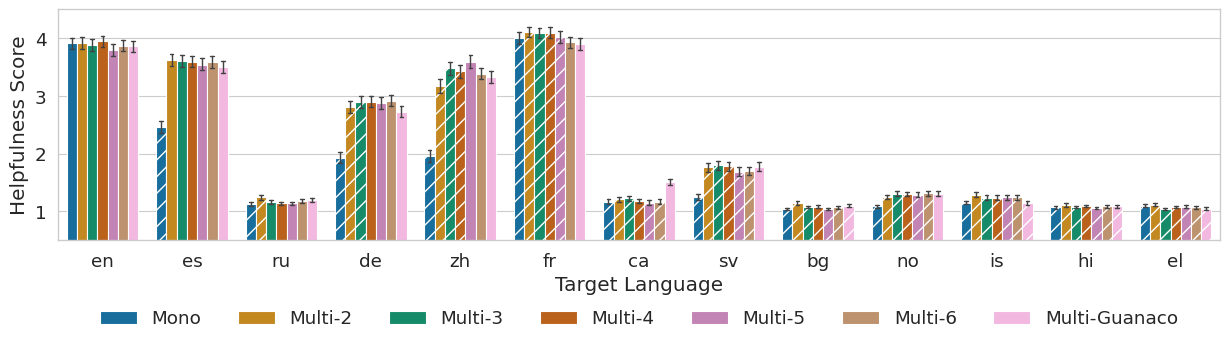

In [19]:
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6', 'Falcon Multi-Guanaco']))]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.strip()
print(len(sdf))
print(sdf['model_name'].value_counts())
plot_llm_judge_score_distribution(
    sdf, 
    # save_path='data/plots/chat_llm_judge_falcon_7b_incremental.png'
    )

['Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6']
saved to data/plots/chat_llm_judge_llama_7b_incremental_languages_n400.png
[8.5 4.5]


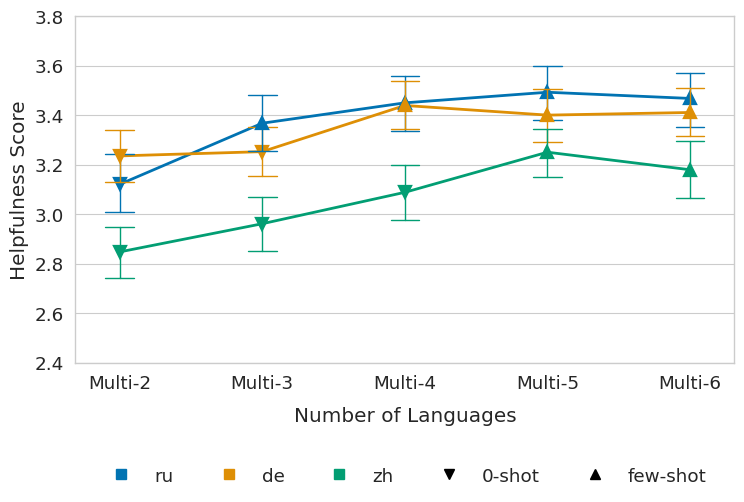

In [44]:
def plot_llm_judge_score_distribution_ablation_on_n_langs(df, title=None, xlabel=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(8.5, 4.5))
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(model_names)

    marker_styles = {
        '0-shot': 'v',
        'few-shot': '^', 
    }

    # need to explicitly define ylims to ensure correct scaling with other plots
    ax.set_ylim([2.4, 3.8])
    # ax.set_ylim([1.3, 3.7])
    # ax.set_yticks(np.arange(1.3, 3.7, 0.3))
    # plot the lines using matplotlib
    for test_set in test_sets:
        # Extract the subset for each test set
        subset = df[df['test_set'] == test_set]
        # compute mean for each model on each test set
        subset = subset.groupby(['model_name', 'test_set'], as_index=False).mean(numeric_only=True)
        # Plot the lineplot for this subset
        ax.plot(subset['model_name'], subset['eval_score'], 
                linestyle='-', 
                marker='', 
                label=test_set, 
                linewidth=2.0, 
                color=sns.color_palette()[test_sets.index(test_set)]
                )

    # ax.set_yticks(np.arange(1.3, 3.7, 0.3))

    # Now, overlay the points with different markers for each condition
    # Iterate over each condition and plot separately
    for condition, marker in marker_styles.items():
        # Create a subset of the dataframe for the current condition
        subset = df[df['condition'] == condition]

        # Plot the pointplot for this subset
        sns.pointplot(data=subset, x='model_name', y='eval_score', hue='test_set', ax=ax,
                    errorbar=("ci", 95), capsize=0.2,
                    err_kws={"linewidth": 1.0},
                    alpha=1.0,
                    order=model_names,
                    hue_order=test_sets,
                    linestyles='',  # No lines for pointplot
                    markers=marker,  # Use the specific marker for this condition
                    markersize=8,
                    )
    
    # set yticks
    # ax.set_yticks(np.arange(1.3, 3.7, 0.3))

    # pad xlabel             
    ax.set_xlabel(xlabel, labelpad=10)
    ax.set_ylabel('Helpfulness Score')

    ax.set_title(title)

    # build custom legend
    legend = ax.get_legend() 
    legend_colors = [handle.get_color() for handle in legend.legend_handles][:len(test_sets)]
    # get labels from legend
    labels = [text.get_text() for text in legend.get_texts()][:len(test_sets)]
    
    # define proxy artists for legend
    f = lambda m,c: plt.plot([], [], marker=m, color=c, ls="none")[0]

    handles = [f("s", i) for i in legend_colors]
    handles += [f(i, "k") for i in marker_styles.values()]
    labels = labels[:len(test_sets)] + list(marker_styles.keys())
    
    # increase legend marker size
    for handle in handles:
        handle.set_markersize(7.0)

    # legend at bottom
    ncols = len(handles)
    y_offset = -0.4
    ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', pad_inches=0.1, dpi=300)
        print(f'saved to {save_path}')
        print(f'{fig.get_size_inches()}')

    return

# rename model_name as percentage of non-english examples
def rename_model_name(x):
    ml_count = re.search(r'Multi-([0-9])', x).group(1)
    ne_count = int(ml_count)-1

    total_ne = int(x.split("=")[1]) * ne_count

    ne_perc = (total_ne / 3200) * 100

    # round to nearest 0.5
    # ne_perc = round(ne_perc * 2) / 2
    return f'{total_ne}\n({ne_perc:.2f}%)'


# sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT Multi-2 N=1000', 'Llama-2 MT Multi-3 N=500', 'Llama-2 MT Multi-4 N=333']))]
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin([
    # 'Llama-2 Mono', 
    'Llama-2 MT Multi-2 N=400', 
    'Llama-2 MT Multi-3', 
    'Llama-2 MT Multi-4 N=133', 
    'Llama-2 MT Multi-5 N=100',
    'Llama-2 MT Multi-6 N=80',
    ]))]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[sdf['test_set'].isin(['ru', 'de', 'zh'])]

sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('MT', '').str.strip()
# remove N=* from model_name
sdf['model_name'] = sdf['model_name'].apply(lambda x: x.split(' ')[0])

# add conditions for different markers indicating 0-shot or few-shot
sdf['condition'] = '0-shot'
for i, row in sdf.iterrows():
    if ('Multi-3' in row['model_name'] or 'Multi-4' in row['model_name'] or 'Multi-5' in row['model_name'] or 'Multi-6' in row['model_name']) and row['test_set'] == 'ru':
        sdf.loc[i, 'condition'] = 'few-shot'
    elif ('Multi-4' in row['model_name'] or 'Multi-5' in row['model_name'] or 'Multi-6' in row['model_name']) and row['test_set'] == 'de':
        sdf.loc[i, 'condition'] = 'few-shot'
    elif ('Multi-5' in row['model_name'] or 'Multi-6' in row['model_name']) and row['test_set'] == 'zh':
        sdf.loc[i, 'condition'] = 'few-shot'

plot_llm_judge_score_distribution_ablation_on_n_langs(
    sdf, 
    xlabel='Number of Languages',
    save_path='data/plots/chat_llm_judge_llama_7b_incremental_languages_n400.png'
)


100\n(3.12%)      2697
1000\n(31.25%)    2696
400\n(12.50%)     2695
200\n(6.25%)      2694
10\n(0.31%)          0
20\n(0.62%)          0
50\n(1.56%)          0
300\n(9.38%)         0
Name: model_name, dtype: int64
['100\n(3.12%)', '200\n(6.25%)', '400\n(12.50%)', '1000\n(31.25%)']
Categories (8, object): ['10\n(0.31%)', '20\n(0.62%)', '50\n(1.56%)', '100\n(3.12%)', '200\n(6.25%)', '300\n(9.38%)', '400\n(12.50%)', '1000\n(31.25%)']


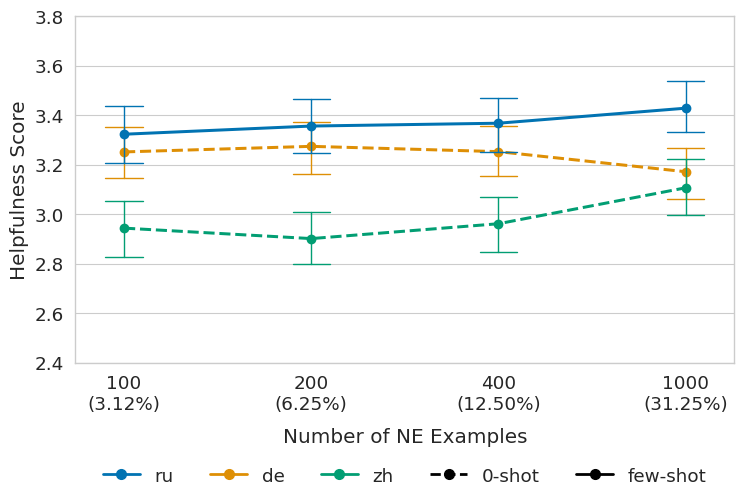

In [45]:
# ablation study incremental ML examples for ML3

def plot_llm_judge_score_distribution_ablation_on_n_examples(df, title=None, xlabel=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(8.5, 4.5))
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(model_names)

    line_styles = {
        '0-shot': '--',
        'few-shot': '-', 
    }

    # need to explicitly define ylims to ensure correct scaling with other plots
    ax.set_ylim([2.4, 3.8])
    
    for condition, ls in line_styles.items():
        # Create a subset of the dataframe for the current condition
        subset = df[df['condition'] == condition]

        # Plot the pointplot for this subset
        sns.pointplot(data=subset, x='model_name', y='eval_score', hue='test_set', ax=ax,  
                    errorbar=("ci", 95), capsize=0.2,
                    err_kws={"linewidth": 1.0},
                    alpha=1.0,
                    order=model_names,
                    hue_order=test_sets,
                    linestyles=ls,
                    )
        
    # pad xlabel             
    ax.set_xlabel(xlabel, labelpad=10)
    ax.set_ylabel('Helpfulness Score')

    # show yticks at 0.5 intervals
    # ax.set_yticks(np.arange(1.3, 3.7, 0.3))    

    ax.set_title(title)

    if len(df['condition'].unique()) > 1:

        # build custom legend
        legend = ax.get_legend() 
        legend_colors = [handle.get_color() for handle in legend.legend_handles][:len(test_sets)]
        # get labels from legend
        labels = [text.get_text() for text in legend.get_texts()][:len(test_sets)]
        
        # define proxy artists for legend
        f = lambda ls, c: plt.plot([], [], linestyle=ls, color=c, marker='o', linewidth=2)[0]

        handles = [f("-", i) for i in legend_colors]
        handles += [f(i, "k") for i in line_styles.values()]
        labels = labels[:len(test_sets)] + list(line_styles.keys())
        
        # increase legend marker size
        for handle in handles:
            handle.set_markersize(7.0)

        # legend at bottom
        ncols = len(handles)
        y_offset = -0.4
        ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    else:
        # legend at bottom
        ncols = len(test_sets)
        y_offset = -0.4
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', pad_inches=0.1, dpi=300)
        print(f'saved to {save_path}')

    return

sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin([
    # 'Llama-2 Mono',
    # 'Llama-2 MT Multi-3 N=5', 
    # 'Llama-2 MT Multi-3 N=10', 
    # 'Llama-2 MT Multi-3 N=25', 
    'Llama-2 MT Multi-3 N=50', 
    'Llama-2 MT Multi-3 N=100',
    'Llama-2 MT Multi-3 N=150',
    'Llama-2 MT Multi-3',
    'Llama-2 MT Multi-3 N=500', 
    ]
    ))]
# sdf = sdf[sdf['test_set'].isin(['de'])]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[sdf['test_set'].isin(['ru', 'de', 'zh'])]

sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]

# rename model_name 'Llama-2 MT Multi-3' to 'Llama-2 MT Multi-3 N=200'
sdf['model_name'].replace({'Llama-2 MT Multi-3': 'Llama-2 MT Multi-3 N=200', 'Llama-2 Mono': 'Llama-2 MT Multi-3 N=0'}, inplace=True)
# reorder dataframe by model_name from least to most examples
sdf['model_name'] = pd.Categorical(
    sdf['model_name'], 
    [
        # 'Llama-2 MT Multi-3 N=0',
        'Llama-2 MT Multi-3 N=5', 
        'Llama-2 MT Multi-3 N=10', 
        'Llama-2 MT Multi-3 N=25', 
        'Llama-2 MT Multi-3 N=50', 
        'Llama-2 MT Multi-3 N=100', 
        'Llama-2 MT Multi-3 N=150', 
        'Llama-2 MT Multi-3 N=200',
        'Llama-2 MT Multi-3 N=500',
    ]
)
sdf = sdf.sort_values(by=['model_name'])

sdf['model_name'] = sdf['model_name'].apply(rename_model_name)

print(sdf['model_name'].value_counts())

sdf['condition'] = sdf.apply(lambda x: '0-shot' if x['test_set'] in ['de', 'zh'] else 'few-shot', axis=1)

plot_llm_judge_score_distribution_ablation_on_n_examples(
    sdf, 
    xlabel='Number of NE Examples',
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_examples_ml2.png'
    )


100\n(3.12%)      2698
1000\n(31.25%)    2698
50\n(1.56%)       2693
200\n(6.25%)      2693
400\n(12.50%)     2693
300\n(9.38%)         0
Name: model_name, dtype: int64
['50\n(1.56%)', '100\n(3.12%)', '200\n(6.25%)', '400\n(12.50%)', '1000\n(31.25%)']
Categories (6, object): ['50\n(1.56%)', '100\n(3.12%)', '200\n(6.25%)', '300\n(9.38%)', '400\n(12.50%)', '1000\n(31.25%)']
saved to data/plots/chat_llm_judge_llama_7b_incremental_examples_ml2.png


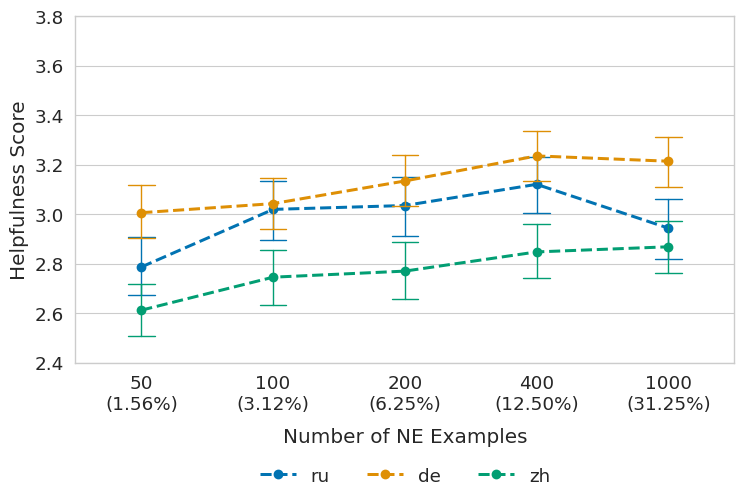

In [46]:
sdf = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin([
    # 'Llama-2 Mono',
    'Llama-2 MT Multi-2 N=50', 
    'Llama-2 MT Multi-2 N=100', 
    'Llama-2 MT Multi-2', 
    # 'Llama-2 MT Multi-2 N=300', 
    'Llama-2 MT Multi-2 N=400',
    'Llama-2 MT Multi-2 N=1000'
    ]))]

sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[sdf['test_set'].isin(['de', 'zh', 'ru'])]

sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
# rename model_name 'Llama-2 MT Multi-3' to 'Llama-2 MT Multi-3 N=200'
sdf['model_name'].replace({
    'Llama-2 Mono': 'Llama-2 MT Multi-2 N=0',
    'Llama-2 MT Multi-2': 'Llama-2 MT Multi-2 N=200'
    }, inplace=True)
# reorder dataframe by model_name from least to most examples
sdf['model_name'] = pd.Categorical(sdf['model_name'], [
    # 'Llama-2 MT Multi-2 N=0', 
    'Llama-2 MT Multi-2 N=50', 
    'Llama-2 MT Multi-2 N=100', 
    'Llama-2 MT Multi-2 N=200', 
    'Llama-2 MT Multi-2 N=300', 
    'Llama-2 MT Multi-2 N=400', 
    'Llama-2 MT Multi-2 N=1000'
    ])
sdf = sdf.sort_values(by=['model_name'])

sdf['model_name'] = sdf['model_name'].apply(rename_model_name)

print(sdf['model_name'].value_counts())
# print(len(sdf))

sdf['condition'] = sdf.apply(lambda x: '0-shot' if x['test_set'] in ['ru', 'de', 'zh'] else 'few-shot', axis=1)

plot_llm_judge_score_distribution_ablation_on_n_examples(
    sdf, 
    xlabel='Number of NE Examples',
    save_path='data/plots/chat_llm_judge_llama_7b_incremental_examples_ml2.png'
    )


70131
70092
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,'],
      dtype='object')
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,'],
      dtype='object')
[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451)]
[<matplotlib.lines.Line2D object at 0x7f704c6136a0>, <matplotlib.line

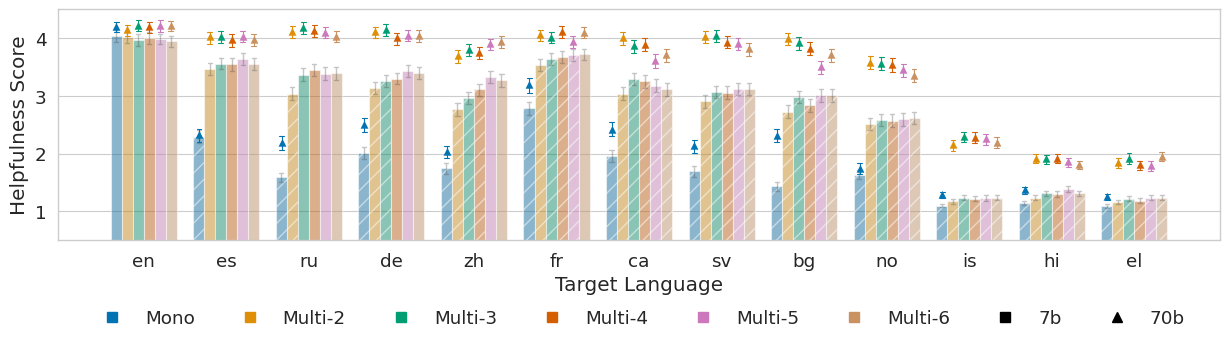

In [49]:
def plot_llm_judge_score_distribution_differences_v1(df1, df2, df1_id, df2_id, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets_1 = [l for l in ordered_alpaca_test_sets if l in df1['test_set'].unique()]
    test_sets_2 = [l for l in ordered_alpaca_test_sets if l in df2['test_set'].unique()]

    if test_sets_1 != test_sets_2:
        raise RuntimeError('test sets are not equal!')
        
    model_names_1 = [m for m in df1['model_name'].unique()]
    model_names_2 = [m for m in df2['model_name'].unique()]
    
    markers = ['s', '^']
    
    # baseline setting
    sns.barplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), capsize=0.3,
                # errorbar='sd', capsize=0.3,
                err_kws={"linewidth": 1.0, "alpha": 0.3},
                alpha=0.5,
                order=test_sets_1,
                hue_order=model_names_1,
                )
    
    # # set alpha of error bars to 0.5
    # for errorbar in ax.lines[1::2]:
    #     errorbar.set_alpha(0.5)

    # experimental setting
    sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), capsize=0.06,
                # errorbar='sd', capsize=0.3,
                err_kws={
                    "linewidth": 0.8, 
                    # "alpha": 0.6, 
                    # "color": "k"
                    },
                alpha=1.0,
                markers=markers[1], 
                markersize=3.0,
                order=test_sets_2,
                hue_order=model_names_2,
                dodge=0.66,
                linestyle='none',
                )

    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets_1):
        for j, model_name in enumerate(model_names_1):
            # The index of the bar in the patches list
            index = i * len(model_names_1) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] not in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness Score')
    
    # fix ylim to 1-6
    ax.set_ylim(0.5, 4.5)

    ax.set_title(title)

    legend = ax.get_legend()

    legend_colors = []
    for handle in legend.legend_handles:
        if isinstance(handle, mlines.Line2D):
            legend_colors.append(handle.get_color())
        else:
            pass

    legend_colors = legend_colors[:len(model_names_1)]
    print(legend_colors)
    
    # define proxy artists for legend
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

    handles = [f("s", i) for i in legend_colors]
    handles += [f(i, "k") for i in markers]

    # get labels from legend
    labels = [text.get_text() for text in legend.get_texts()][:len(model_names_1)] + [df1_id, df2_id]
    
    print(handles)
    print(labels)
    
    # increase legend marker size
    for handle in handles:
        handle.set_markersize(7.0)

    # add custom legend
    ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.45), ncols=8, frameon=False)

    # get custom legend using only df1
    # handles, labels = ax.get_legend_handles_labels()
    # print(handles)
    # print(labels)
    # handles = handles[:len(model_names_1)]
    # labels = labels[:len(model_names_1)]

    # # set the colors of the handles to have alpha=1
    # for handle in handles:
    #     handle.set_alpha(1.0)

    # # add custom legend
    # ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.45), ncols=8, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

sdf1 = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-6']))]
sdf1 = sdf1[sdf1['test_set'].isin(ordered_alpaca_test_sets)]
# sdf1 = sdf1[~sdf1['test_set'].isin(['en', 'es', 'ru', 'de', 'zh', 'fr'])]
# sdf1 = sdf1[~sdf1['test_set'].isin(['ca', 'sv', 'bg', 'no', 'hi', 'el'])]
# sdf1 = sdf1[~sdf1['test_set'].isin(['is'])]

sdf1 = sdf1[ (sdf1['eval_src'] == 'source') & (sdf1['eval_tgt'] == 'system') ]
sdf1['model_name'] = sdf1['model_name'].str.replace('Llama-2', '').str.replace('MT', '').str.strip()
print(len(sdf1))
sdf2 = df[(df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6']))]
sdf2 = sdf2[sdf2['test_set'].isin(ordered_alpaca_test_sets)]
# sdf2 = sdf2[~sdf2['test_set'].isin(['en', 'es', 'ru', 'de', 'zh', 'fr'])]
# sdf2 = sdf2[~sdf2['test_set'].isin(['ca', 'sv', 'bg', 'no', 'hi', 'el'])]
# sdf2 = sdf2[~sdf2['test_set'].isin(['is'])]

sdf2 = sdf2[ (sdf2['eval_src'] == 'source') & (sdf2['eval_tgt'] == 'system') ]
sdf2['model_name'] = sdf2['model_name'].str.replace('Llama-2 70B', '').str.replace('MT', '').str.strip()
print(len(sdf2))
print(sdf1.columns)
print(sdf2.columns)

plot_llm_judge_score_distribution_differences_v1(
    sdf1,
    sdf2, 
    df1_id='7b',
    df2_id='70b',
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_70b.png'
    )



58443
58443
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,'],
      dtype='object')
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'id', 'eval_reasoning', 'eval_score',
       'source_lang', 'system_lang', 'context', 'n_eval_items', 'data_seed',
       'api_seed', 'eval_model', 'eval_Pizzeria,'],
      dtype='object')
['Multi-2', 'Multi-3', 'Multi-4', 'Multi-5', 'Multi-6']


/tmp/ipykernel_970574/1300087478.py:22: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,


Before plotting pp2
lines <Axes.ArtistList of 25 lines>
collections <Axes.ArtistList of 0 collections>


/tmp/ipykernel_970574/1300087478.py:46: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,


After plotting pp2
lines <Axes.ArtistList of 50 lines>
collections <Axes.ArtistList of 0 collections>
30 [(-0.33, 2.9877641824249164), (-0.264, 3.0345596432552955), (-0.165, 3.3363128491620113), (-0.099, 3.3670745272525027), (0.0, 3.344097995545657), (0.066, 3.447045707915273), (0.16499999999999998, 3.368186874304783), (0.23099999999999998, 3.3859844271412682), (0.33, 3.361915367483296), (0.396, 3.393095768374165), (0.6699999999999999, 3.2814238042269186), (0.736, 3.133630289532294), (0.835, 3.253615127919911), (0.901, 3.252222222222222), (1.0, 3.261401557285873), (1.066, 3.3), (1.165, 3.338888888888889), (1.231, 3.433333333333333), (1.33, 3.3092324805339266), (1.3960000000000001, 3.391111111111111), (1.67, 2.7416481069042318), (1.736, 2.769487750556793), (1.835, 3.097777777777778), (1.901, 2.9609375), (2.0, 3.0144927536231885), (2.066, 3.111111111111111), (2.165, 3.202447163515017), (2.231, 3.3303670745272527), (2.33, 3.2558398220244715), (2.396, 3.2703003337041157)]
['Multi-2', 'Mult

/tmp/ipykernel_970574/1300087478.py:22: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,


Before plotting pp2
lines <Axes.ArtistList of 25 lines>
collections <Axes.ArtistList of 0 collections>


/tmp/ipykernel_970574/1300087478.py:46: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,


After plotting pp2
lines <Axes.ArtistList of 50 lines>
collections <Axes.ArtistList of 0 collections>
30 [(-0.33, 3.6224944320712695), (-0.264, 3.467185761957731), (-0.165, 3.5877777777777777), (-0.099, 3.56), (0.0, 3.5322222222222224), (0.066, 3.542825361512792), (0.16499999999999998, 3.6855555555555557), (0.23099999999999998, 3.6384872080088986), (0.33, 3.612222222222222), (0.396, 3.548888888888889), (0.6699999999999999, 3.6073414905450503), (0.736, 3.53), (0.835, 3.7552836484983314), (0.901, 3.6366666666666667), (1.0, 3.6844444444444444), (1.066, 3.6766666666666667), (1.165, 3.732222222222222), (1.231, 3.7048997772828507), (1.33, 3.6911111111111112), (1.3960000000000001, 3.72), (1.67, 3.082222222222222), (1.736, 3.04), (1.835, 3.316666666666667), (1.901, 3.287777777777778), (2.0, 3.2558398220244715), (2.066, 3.255011135857461), (2.165, 3.151111111111111), (2.231, 3.1766666666666667), (2.33, 3.1055555555555556), (2.396, 3.1134593993325916)]
['Multi-2', 'Multi-3', 'Multi-4', 'Multi-5'

/tmp/ipykernel_970574/1300087478.py:22: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,


Before plotting pp2
lines <Axes.ArtistList of 25 lines>
collections <Axes.ArtistList of 0 collections>


/tmp/ipykernel_970574/1300087478.py:46: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,


After plotting pp2
lines <Axes.ArtistList of 50 lines>
collections <Axes.ArtistList of 0 collections>
30 [(-0.33, 2.9465478841870825), (-0.264, 2.9043381535038932), (-0.165, 3.0155728587319244), (-0.099, 3.067853170189099), (0.0, 2.959955506117909), (0.066, 3.056729699666296), (0.16499999999999998, 3.081111111111111), (0.23099999999999998, 3.1191536748329622), (0.33, 3.0902004454342986), (0.396, 3.123608017817372), (0.6699999999999999, 2.6407119021134595), (0.736, 2.720800889877642), (0.835, 2.707777777777778), (0.901, 2.9777530589543937), (1.0, 2.796440489432703), (1.066, 2.8398220244716352), (1.165, 2.9010011123470525), (1.231, 3.01), (1.33, 2.8333333333333335), (1.3960000000000001, 3.006674082313682), (1.67, 2.5450500556173528), (1.736, 2.5083426028921023), (1.835, 2.5517241379310347), (1.901, 2.582869855394883), (2.0, 2.4966666666666666), (2.066, 2.57174638487208), (2.165, 2.661111111111111), (2.231, 2.5951056729699666), (2.33, 2.6422222222222222), (2.396, 2.618888888888889)]
['Mul

/tmp/ipykernel_970574/1300087478.py:22: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,


Before plotting pp2
lines <Axes.ArtistList of 25 lines>
collections <Axes.ArtistList of 0 collections>


/tmp/ipykernel_970574/1300087478.py:46: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,


After plotting pp2
lines <Axes.ArtistList of 50 lines>
collections <Axes.ArtistList of 0 collections>
30 [(-0.33, 1.1866666666666668), (-0.264, 1.1711111111111112), (-0.165, 1.1933333333333334), (-0.099, 1.2366666666666666), (0.0, 1.2057842046718577), (0.066, 1.2122222222222223), (0.16499999999999998, 1.2202447163515018), (0.23099999999999998, 1.2291434927697442), (0.33, 1.1926503340757237), (0.396, 1.235817575083426), (0.6699999999999999, 1.3177777777777777), (0.736, 1.2366666666666666), (0.835, 1.318888888888889), (0.901, 1.311457174638487), (1.0, 1.3768115942028984), (1.066, 1.3070077864293659), (1.165, 1.3544444444444443), (1.231, 1.3815350389321468), (1.33, 1.3403781979977754), (1.3960000000000001, 1.31), (1.67, 1.1601779755283648), (1.736, 1.1655555555555555), (1.835, 1.2162764771460424), (1.901, 1.2177777777777778), (2.0, 1.1959910913140313), (2.066, 1.1854748603351954), (2.165, 1.2082405345211582), (2.231, 1.2333333333333334), (2.33, 1.2369299221357064), (2.396, 1.2313681868743

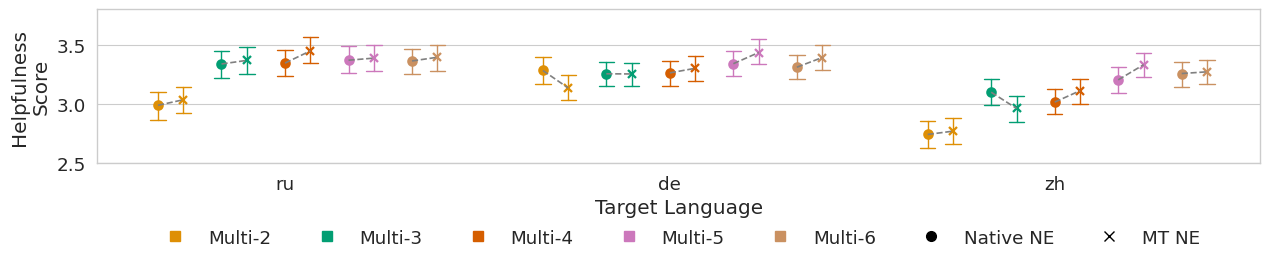

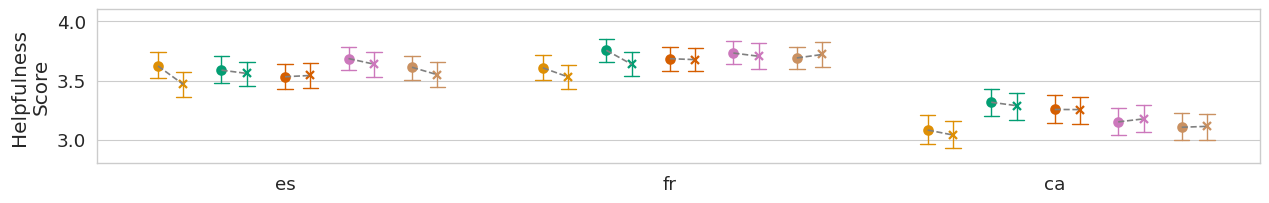

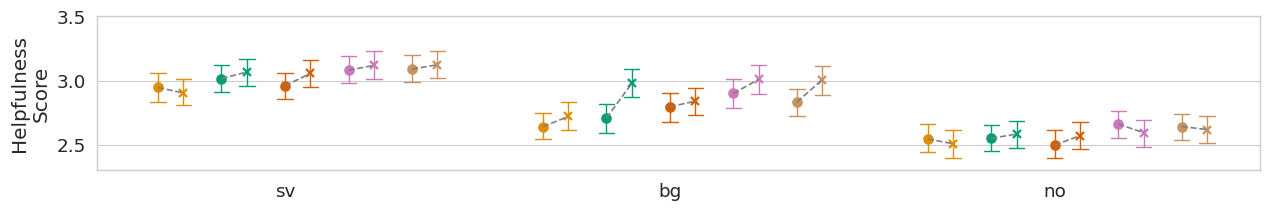

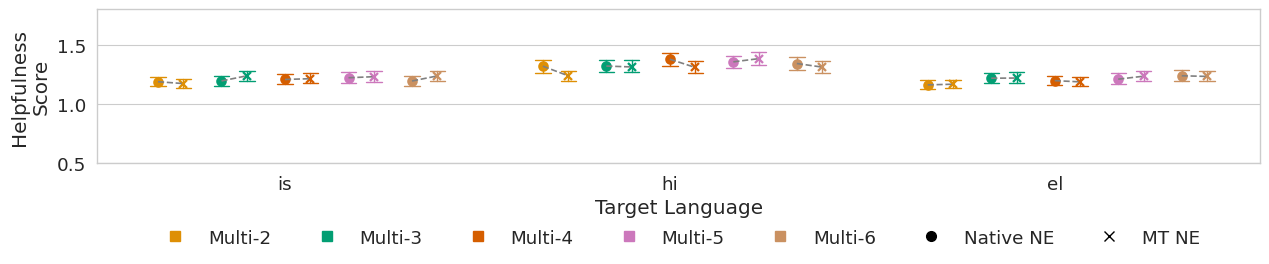

In [50]:
def plot_llm_judge_score_distribution_differences_v2(df1, df2, df1_id, df2_id, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 2))
    
    test_sets_1 = [l for l in ordered_alpaca_test_sets if l in df1['test_set'].unique()]
    test_sets_2 = [l for l in ordered_alpaca_test_sets if l in df2['test_set'].unique()]

    if test_sets_1 != test_sets_2:
        raise RuntimeError('test sets are not equal!')
        
    model_names_1 = [m for m in df1['model_name'].unique()]
    model_names_2 = [m for m in df2['model_name'].unique()]
    
    print(model_names_1)
    
    dodge_value = 0.66
    markers = ['o', 'x']

    offset = 0.066

    pp1 = sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95),
                capsize=0.04,
                err_kws={
                    "linewidth": 1.0, 
                    # "color": "k"
                    }, 
                markersize=6.0,
                alpha=1.0,
                markers=markers[0],
                order=test_sets_1,
                hue_order=model_names_1,
                dodge=dodge_value,
                linestyle='none',
                palette=sns.color_palette()[1:],
                )
    
    # Record the number of lines and collections before plotting pp2
    num_lines_before = len(ax.lines)
    num_collections_before = len(ax.collections)
    print('Before plotting pp2')
    print('lines', ax.lines)
    print('collections', ax.collections)

    pp2 = sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), 
                capsize=0.04, 
                err_kws={
                    "linewidth": 1.0, 
                    # "color": "k"
                    }, 
                markersize=6.0,
                alpha=1.0,
                markers=markers[1], 
                order=test_sets_2,
                hue_order=model_names_2,
                dodge=dodge_value,
                linestyle='none',
                palette=sns.color_palette()[1:],
                )
    
    print('After plotting pp2')
    print('lines', ax.lines)
    print('collections', ax.collections)

    # Shift only the lines and collections added by pp2
    for i, line in enumerate(ax.lines[num_lines_before:]):
        x_positions = line.get_xdata()
        # print(i, line, x_positions)
        x_positions = [x + offset for x in x_positions]
        # print(i, line, x_positions)
        line.set_xdata(x_positions)

    # Function to check if a line represents a single point
    def is_single_point_line(line):
        x_data, y_data = line.get_data()
        # only interested in lines with 3 points (lines with nan values indicate error bars)
        return len(x_data) == 3 and len(y_data) == 3

    # Extracting coordinates for single-point lines
    line_points = []
    for line in ax.lines:
        if is_single_point_line(line):
            x, y = line.get_data()
            for i in range(len(x)):
                line_points.append((x[i], y[i]))
    

    # sort line_points by x coordinate
    line_points = sorted(line_points, key=lambda x: x[0])
    print(len(line_points), line_points)

    # # draw lines from line_coordinates [0, 1], [2, 3], [4, 5], ...
    # colors = sns.color_palette()[1:]
    for i in range(0, len(line_points), 2):
        x1, y1 = line_points[i]
        x2, y2 = line_points[i + 1]
        # color = colors[i // 2 % len(colors)]
        # print(color)
        plt.plot([x1, x2], [y1, y2], linestyle='--', color='gray')

    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness\nScore')
    
    if test_sets_1 == ['ru', 'de', 'zh']:
        ax.set_ylim(2.5, 3.8)
    elif test_sets_1 == ['es', 'fr', 'ca']:
        ax.set_ylim(2.8, 4.1)
    elif test_sets_1 == ['sv', 'bg', 'no']:
        ax.set_ylim(2.3, 3.5)
    elif test_sets_1 == ['is', 'hi', 'el']:
        ax.set_ylim(0.5, 1.8)
        
    ax.set_title(title)

    legend = ax.get_legend()    
    legend_colors = [handle.get_color() for handle in legend.legend_handles][:len(model_names_1)]

    # get labels from legend
    labels = [text.get_text() for text in legend.get_texts()][:len(model_names_1)]

    # define proxy artists for legend
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

    handles = [f("s", i) for i in legend_colors]
    handles += [f(i, "k") for i in markers]

    # get colors from df1 and shapes from df1 and df2
    labels = labels[:len(model_names_1)] + [df1_id, df2_id]

    # increase legend marker size
    for handle in handles:
        handle.set_markersize(7.0)

    # add custom legend
    ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.65), ncols=8, frameon=False)

    if test_sets_1 == ['es', 'fr', 'ca'] or test_sets_1 == ['sv', 'bg', 'no']:
        # hide legened
        legend.remove()
        # hide x-axis label
        ax.set_xlabel('')

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

sdf1 = df[ (df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6']))]
sdf1 = sdf1[sdf1['test_set'].isin(ordered_alpaca_test_sets)]
sdf1 = sdf1[ (sdf1['eval_src'] == 'source') & (sdf1['eval_tgt'] == 'system') ]
sdf1['model_name'] = sdf1['model_name'].str.replace('Llama-2 ', '').str.strip()
print(len(sdf1))
sdf2 = df[ (df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 MT Multi-2', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-6']))]
sdf2 = sdf2[sdf2['test_set'].isin(ordered_alpaca_test_sets)]
sdf2 = sdf2[ (sdf2['eval_src'] == 'source') & (sdf2['eval_tgt'] == 'system') ]
sdf2['model_name'] = sdf2['model_name'].str.replace('Llama-2', '').str.strip()
print(len(sdf2))
print(sdf1.columns)
print(sdf2.columns)


plot_llm_judge_score_distribution_differences_v2(
    sdf1[sdf1['test_set'].isin(['ru', 'de', 'zh'])],
    sdf2[sdf2['test_set'].isin(['ru', 'de', 'zh'])],
    'Native NE',
    'MT NE',
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_mt.png'
    )

plot_llm_judge_score_distribution_differences_v2(
    sdf1[sdf1['test_set'].isin(['es', 'fr', 'ca'])],
    sdf2[sdf2['test_set'].isin(['es', 'fr', 'ca'])],
    'Native NE',
    'MT NE',
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_mt_additional_langs_1.png'
    )

plot_llm_judge_score_distribution_differences_v2(
    sdf1[sdf1['test_set'].isin(['sv', 'bg', 'no'])],
    sdf2[sdf2['test_set'].isin(['sv', 'bg', 'no'])],
    'Native NE',
    'MT NE',
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_mt_additional_langs_2.png'
    )

plot_llm_judge_score_distribution_differences_v2(
    sdf1[sdf1['test_set'].isin(['is', 'hi', 'el'])],
    sdf2[sdf2['test_set'].isin(['is', 'hi', 'el'])],
    'Native NE',
    'MT NE',
    # save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_mt_additional_langs_3.png'
    )
  

ca    1800
bg    1800
no    1800
es    1799
zh    1799
el    1799
de    1798
fr    1798
sv    1798
is    1798
ru    1796
hi    1788
en     899
Name: test_set, dtype: int64


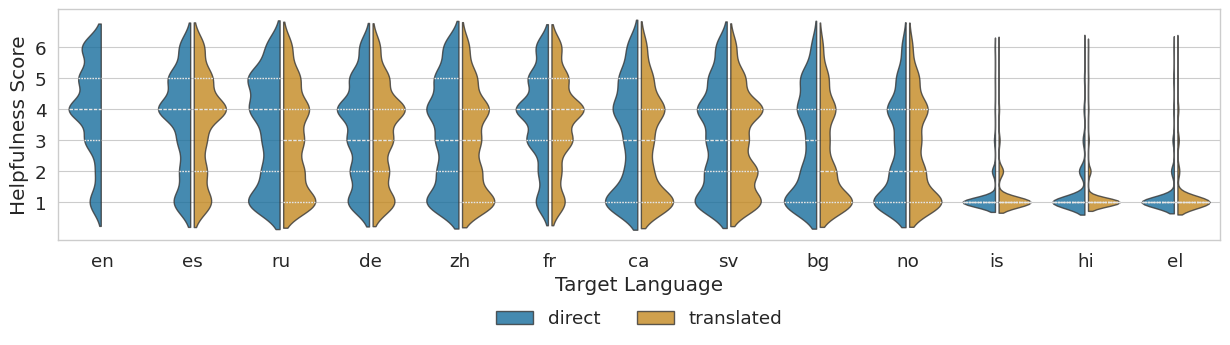

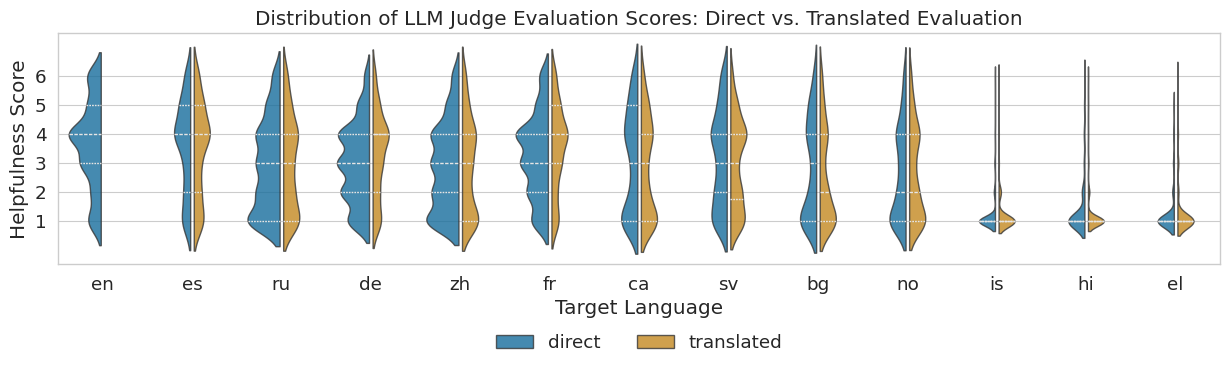

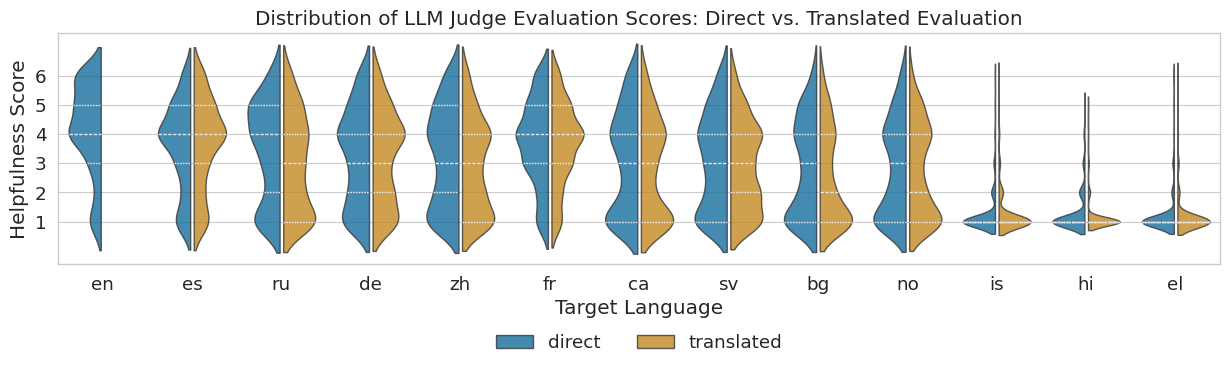

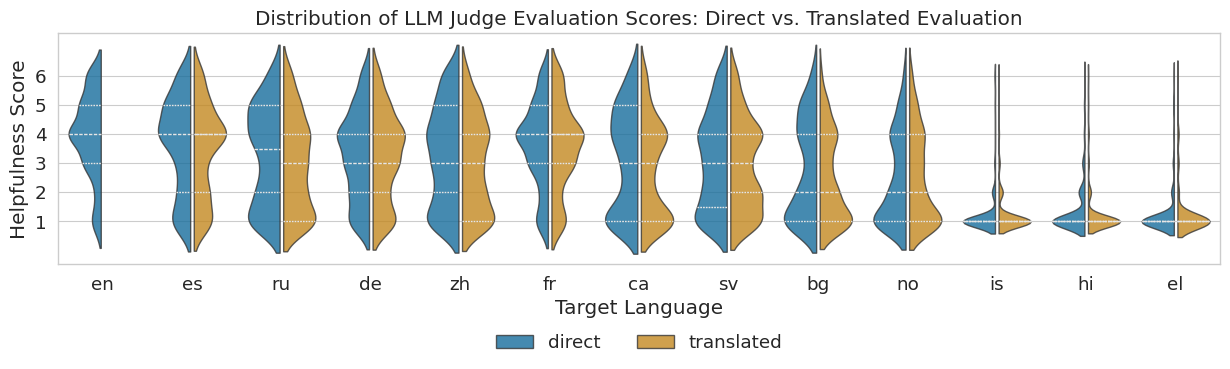

In [51]:

def plot_score_distribution_with_split_violins(df, title=None, save_path=None, hue='eval_type'):

    # for each test set, plot the distribution of eval_score for each model
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    
    fig, ax = plt.subplots(figsize=(15, 3))
    
    sns.violinplot(data=df, x='test_set', y='eval_score', hue=hue, ax=ax, 
                   fill=True, density_norm="count", common_norm=True,
                   split=True,
                   inner="quart",
                   dodge=True, gap=0.1,
                   alpha=0.8,
                   order=test_sets,
                #    inner_kws=dict(box_width=4, whis_width=1, color=".8"),
                   inner_kws=dict(color=".9"),
                   )
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness Score')
    
    # set y-ticks to integers 1-6
    ax.set_yticks(range(1, 7))

    ax.set_title(title)

    # place legend outside of plot at bottom with 3 columns
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=3, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

sdf = df[ (df['eval_model'].str.startswith('gpt-3.5')) & (df['model_name'].isin(['Llama-2 Multi-6'])) ]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf = sdf[~sdf['test_set'].isin(['es', 'ru', 'de', 'zh', 'fr'])]
# sdf = sdf[~sdf['test_set'].isin(['en', 'ca', 'sv', 'bg', 'no', 'hi', 'el'])]
# sdf = sdf[~sdf['test_set'].isin(['is'])]

sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

plot_score_distribution_with_split_violins(
    sdf, 
    # save_path='data/plots/chat_llm_judge_llama_7b_translated_vs_direct_eval.png'
    )

for seed in [0, 42, 723]:
    sdf = df[ (df['model_name'].isin(['Llama-2 Multi-6'])) & (df['seed'] == seed) ] 
    sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]

    sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

    plot_score_distribution_with_split_violins(
        sdf, 
        title='Distribution of LLM Judge Evaluation Scores: Direct vs. Translated Evaluation',
        # save_path=f'data/plots/chat_llm_judge_llama_7b_s{seed}_translated_vs_direct_eval.png'
        )

fr    600
ru    599
de    599
zh    599
en    598
es    300
ca    300
bg    300
no    300
el    300
sv    299
is    299
hi    299
Name: test_set, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5392 entries, 58442 to 80911
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_name      5392 non-null   object 
 1   test_set        5392 non-null   object 
 2   seed            5392 non-null   int64  
 3   eval_src        5392 non-null   object 
 4   eval_tgt        5392 non-null   object 
 5   finish_reason   5392 non-null   object 
 6   secs            5392 non-null   float64
 7   id              5392 non-null   int64  
 8   eval_reasoning  5392 non-null   object 
 9   eval_score      5392 non-null   float64
 10  source_lang     5392 non-null   object 
 11  system_lang     5392 non-null   object 
 12  context         5392 non-null   object 
 13  n_eval_items    5392 non-null   int64  
 14  data

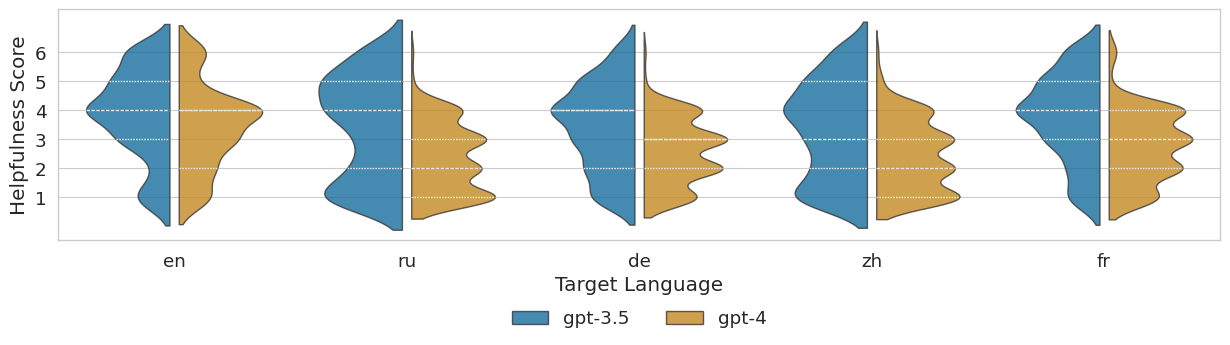

In [52]:
# comparing gpt-3.5 and gpt-4 as judges

sdf = df[ (df['model_name'].isin(['Llama-2 Multi-6'])) ]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[sdf['seed'] == 0]
print(sdf['test_set'].value_counts())
print(sdf.info())

# sdf = sdf[~sdf['test_set'].isin(['en', 'ca', 'sv', 'bg', 'no', 'hi', 'el'])]
# sdf = sdf[~sdf['test_set'].isin(['is'])]

sdf['eval_type'] = sdf.apply(lambda x: "gpt-4" if x['eval_model'].startswith('gpt-4') else "gpt-3.5", axis=1)
# drop test sets that are not available for both gpt-3.5 and gpt-4
gpt4_test_sets = list(sdf[sdf['eval_type'] == 'gpt-4']['test_set'].unique())
gpt35_test_sets = list(sdf[sdf['eval_type'] == 'gpt-3.5']['test_set'].unique())
print(gpt4_test_sets)
print(gpt35_test_sets)
sdf = sdf[sdf['test_set'].isin(gpt4_test_sets) & sdf['test_set'].isin(gpt35_test_sets)]

print(sdf['eval_type'].value_counts())

plot_score_distribution_with_split_violins(
    sdf, 
    # save_path='data/plots/chat_llm_judge_llama_7b_gpt35_vs_gpt4_eval.png'
    )


# LM Eval Harness

In [53]:
def load_lm_eval_results_file(file):
    with open(file, "r", encoding='utf8') as f:
        df = pd.DataFrame.from_dict(json.load(f)['results'])
        df['model_name'] = Path(file).stem
        return df

def get_lm_eval_results(results_dir):
    dfs = []
    for results_file in Path(results_dir).glob('*.json'):
        print(results_file)
        df = load_lm_eval_results_file(results_file)
        dfs.append(df)
    df = pd.concat(dfs, axis=0, ignore_index=False).reset_index()
    df = df.rename(columns={'index': 'metric'})

    # Reshape the dataframe, moving model_name and index to the index
    df_long = pd.melt(df, id_vars=['model_name', 'metric'], var_name='task_lang', value_name='score')

    # Split the task_lang into two separate columns for 'task' and 'lang'
    df_long[['task', 'lang']] = df_long['task_lang'].str.split('_', expand=True)

    # Drop the original task_lang column as it's no longer needed
    df_long.drop('task_lang', axis=1, inplace=True)

    # Now pivot to get the 'task', 'lang' and 'index' as part of the column MultiIndex
    df = df_long.pivot_table(index='model_name', columns=['task', 'lang', 'metric'], values='score')

    # # move model_name to front
    # cols = df.columns.tolist()
    # cols.insert(0, cols.pop(cols.index('model_name')))
    # df = df.reindex(columns=cols)
    
    # # split task and lang tags into multiple levels

    # df.set_index(['model_name', 'metric'], inplace=True)
    # df = df.unstack(level='metric')
    
    df.info()

    return df

df = get_lm_eval_results('data/lm_eval_harness')
df

###################

def process_single_dataset_df(df):

    # multiply all numeric values by 100
    df[df.select_dtypes(include=['number']).columns] *= 100
    # round all numeric values to 2 decimal places
    df = df.round(2)

    # get the list of langs in dataframe from the multi-index
    langs = df.columns.get_level_values(0).unique().tolist()
    
    for lang in langs:
        acc_col = (lang, 'acc')
        stderr_col = (lang, 'acc_stderr') 
        df[lang] = df[acc_col].astype(str) + ' ± ' + df[stderr_col].astype(str)

    # drop all acc_stderr columns from multi-index
    df.drop(df.filter(like='acc_stderr').columns, axis=1, inplace=True)

    # drop 'metric' level from multi-index
    df.columns = df.columns.droplevel(level=1)

    # drop model_name as index
    df.reset_index(inplace=True)

    df.replace({'model_name': name_map}, inplace=True)

    print(df['model_name'].unique())

    # # sort rows by model_name in name_map
    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df = df.sort_values(by=['model_name'])
    # # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    
    # subscript the stderror values in each cell
    # df = df.style.format(lambda x: x.replace('±', '\pm '))

    return df
print('\nPAWS-X\n')
print(process_single_dataset_df(df['pawsx']).to_latex(index=False))
print('\nXNLI\n')
print(process_single_dataset_df(df['xnli']).to_latex(index=False))
print('\nX-Winograd\n')
print(process_single_dataset_df(df['xwinograd']).to_latex(index=False))



data/lm_eval_harness/Llama-2-7b-hf.json
data/lm_eval_harness/falcon_7b_guanaco_merged.json
data/lm_eval_harness/falcon_7b_ml1_merged.json
data/lm_eval_harness/falcon_7b_ml2_merged.json
data/lm_eval_harness/falcon_7b_ml3_merged.json
data/lm_eval_harness/falcon_7b_ml4_merged.json
data/lm_eval_harness/falcon_7b_ml5_merged.json
data/lm_eval_harness/llama_2_70b_hf_guanaco_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml1_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml2_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml3_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml4_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml5_merged.json
data/lm_eval_harness/llama_2_70b_hf_mt_ml6_merged.json
data/lm_eval_harness/llama_2_7b_hf_guanaco_merged.json
data/lm_eval_harness/llama_2_7b_hf_ml1_merged.json
data/lm_eval_harness/llama_2_7b_hf_ml2_merged.json
data/lm_eval_harness/llama_2_7b_hf_ml3_merged.json
data/lm_eval_harness/llama_2_7b_hf_ml4_merged.json
data/lm_eval_harness/llama_2_

/tmp/ipykernel_970574/2368837047.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.select_dtypes(include=['number']).columns] *= 100
/tmp/ipykernel_970574/2368837047.py:86: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(process_single_dataset_df(df['pawsx']).to_latex(index=False))
/tmp/ipykernel_970574/2368837047.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [54]:
def plot_single_dataset_df(df, title=None, save_path=None):

    # df['ci_size'] = df['upper_ci'] - df['lower_ci']
    yerr = [df['acc'] - df['lower_ci'], df['upper_ci'] - df['acc']]

    # get the list of langs in dataframe from the multi-index
    test_sets = df['test_set'].unique().tolist()
    model_names = df['model_name'].unique().tolist()
    
    # # Get the positions of the bars in the barplot
    # x_values = []
    # for test in test_sets:
    #     for i, model in enumerate(model_names):
    #         x_values.append(test_sets.index(test) + i * 0.2 - 0.1)

    fig, ax = plt.subplots(figsize=(15, 3))

    ax = sns.barplot(data=df,
                x='test_set', 
                y='acc', 
                hue='model_name', 
                # errorbar=("ci", 95), capsize=0.3,
                # err_kws={"linewidth": 1.0},
                alpha=1.0,
                # hue_order=ordered_test_sets,
                ax=ax
                )

    # Iterate over each unique test_set and model_name to place the error bars
    for test_set in df['test_set'].unique():
        for model_name in df['model_name'].unique():
            subset = df[(df['test_set'] == test_set) & (df['model_name'] == model_name)]
            if not subset.empty:
                row = subset.iloc[0]
                x = ax.get_xticks()[list(df['test_set'].unique()).index(test_set)]
                hue_offset = 0.115 * list(df['model_name'].unique()).index(model_name) - 0.35
                plt.errorbar(x=x + hue_offset, y=row['acc'], 
                             yerr=[[row['acc'] - row['lower_ci']], [row['upper_ci'] - row['acc']]], 
                             fmt='none', c='black', 
                             linewidth=0.8,
                             capsize=1.8
                             )

    # put legend outside of plot at bottom
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=6)


   # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]
    errorbars = ax.lines

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    sorted_errorbars = sorted(errorbars, key=lambda bar: bar.get_xdata()[0], reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
            # The index of the bar in the patches list
            index = i * len(model_names) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] not in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')

        # custom visualisation for presentation:
        # show only en mono bars
        # if info['test_set'] != 'en':
        #     bar.set_alpha(0.0)
        #     sorted_errorbars[i].set_alpha(0.0)

    ax.set_xlabel('Target Language')
    ax.set_ylabel('Accuracy')
    
    # fix ylim to 1-6
    # ax.set_ylim(0.5, 4.5)

    ax.set_title(title)

    # legend at bottom
    ncols = len(model_names)
    y_offset = -0.45

    # add custom legend
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')


    return

def calculate_95_confidence_intervals(data):
    """
    Adds 95% confidence intervals to the dataset.

    Args:
    data (pd.DataFrame): A DataFrame containing the columns 'acc', 'acc_stderr'.
    
    Returns:
    pd.DataFrame: Original DataFrame with two new columns 'lower_ci' and 'upper_ci'.
    """
    z_score = 1.96  # Z-score for 95% confidence

    # Calculating the confidence intervals
    data['lower_ci'] = data['acc'] - z_score * data['stderr']
    data['upper_ci'] = data['acc'] + z_score * data['stderr']

    return data

def format_dataframe_to_plot(df, dataset_name):

    # print(plot_single_dataset_df(df['pawsx'].unstack(level=0).reset_index()))
    df = df[dataset_name].unstack(level=0).reset_index().rename(columns={0: 'value'})
    # rename model_name using name_map
    df.replace({'model_name': name_map}, inplace=True)

    acc_df = df[df['metric'] == 'acc']
    stderr_df = df[df['metric'] == 'acc_stderr']

    # Merge the dataframes on language and model name
    df = pd.merge(acc_df, stderr_df, on=['lang', 'model_name'])
    df.rename(columns={'value_x': 'acc', 'value_y': 'stderr', 'lang': 'test_set'}, inplace=True)
    df.drop(['metric_x', 'metric_y'], axis=1, inplace=True)

    # rename el to el*
    df['test_set'] = df['test_set'].str.replace('el', 'el')
    df['test_set'] = df['test_set'].str.replace('hi', 'hi')
    

    return calculate_95_confidence_intervals(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_set    63 non-null     object 
 1   model_name  63 non-null     object 
 2   acc         63 non-null     float64
 3   stderr      63 non-null     float64
 4   lower_ci    63 non-null     float64
 5   upper_ci    63 non-null     float64
dtypes: float64(4), object(2)
memory usage: 3.1+ KB
saved to data/plots/xnli_llama2_7b_incremental.png


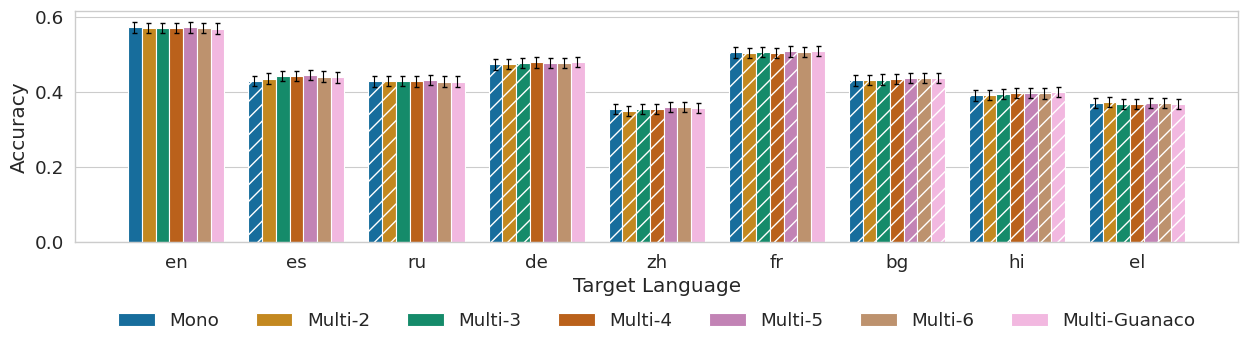

In [29]:
sdf = format_dataframe_to_plot(df, 'xnli')
sdf = sdf[sdf['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 'Llama-2 Multi-Guanaco'])]
sdf = apply_sort(sdf, ordered_test_sets=ordered_alpaca_test_sets)

# drop test sets for presentation plots
# sdf = sdf[sdf['test_set'].isin(['en', 'zh', 'de', 'bg', 'hi'])]

sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.strip()
# sdf[sdf['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2'])].to_csv('scratch/xnli_sample.csv')
sdf

plot_single_dataset_df(
    sdf, 
    # save_path='data/plots/xnli_llama2_7b_incremental.png'
    )



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_set    63 non-null     object 
 1   model_name  63 non-null     object 
 2   acc         63 non-null     float64
 3   stderr      63 non-null     float64
 4   lower_ci    63 non-null     float64
 5   upper_ci    63 non-null     float64
dtypes: float64(4), object(2)
memory usage: 3.1+ KB
saved to data/plots/xnli_falcon_7b_incremental.png


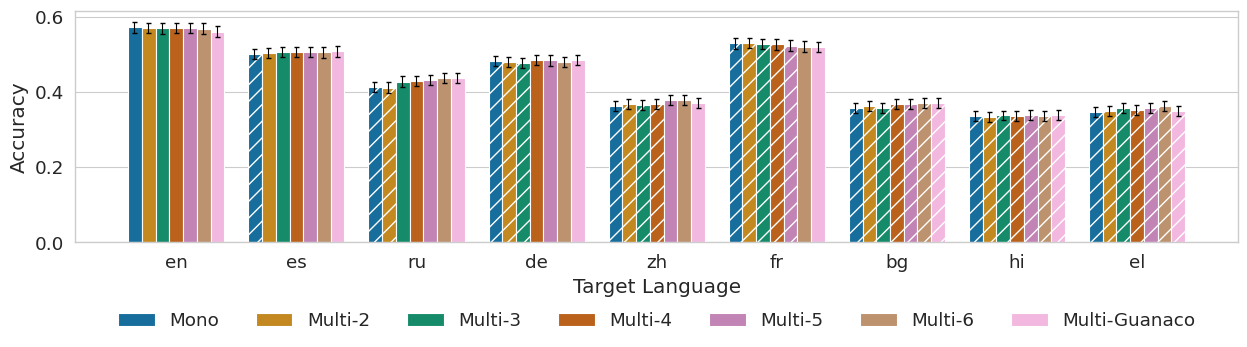

In [30]:
sdf = format_dataframe_to_plot(df, 'xnli')
sdf = sdf[sdf['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6', 'Falcon Multi-Guanaco'])]
sdf = apply_sort(sdf, ordered_test_sets=ordered_alpaca_test_sets)
sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.replace('/ca', '').str.strip()

plot_single_dataset_df(
    sdf, 
    save_path='data/plots/xnli_falcon_7b_incremental.png'
    )



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_set    63 non-null     object 
 1   model_name  63 non-null     object 
 2   acc         63 non-null     float64
 3   stderr      63 non-null     float64
 4   lower_ci    63 non-null     float64
 5   upper_ci    63 non-null     float64
dtypes: float64(4), object(2)
memory usage: 3.1+ KB
saved to data/plots/xnli_llama_70b_incremental.png


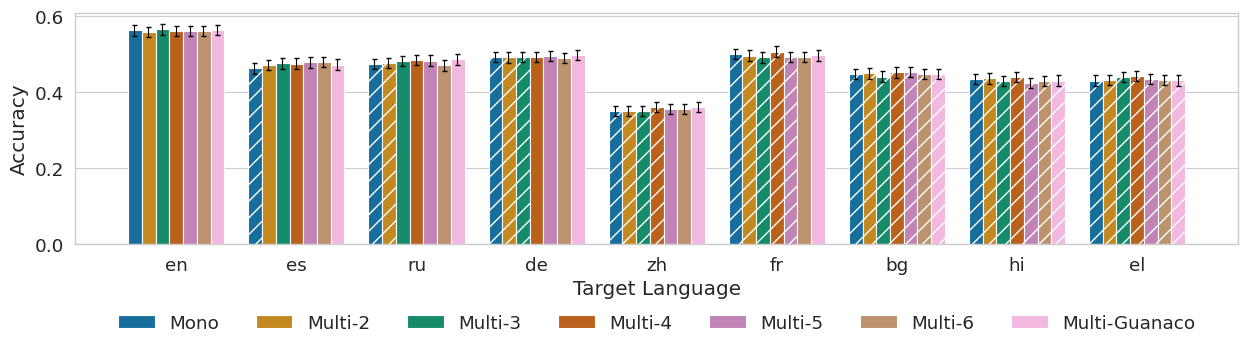

In [31]:
sdf = format_dataframe_to_plot(df, 'xnli')
sdf = sdf[sdf['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6', 'Llama-2 70B Multi-Guanaco'])]
sdf = apply_sort(sdf, ordered_test_sets=ordered_alpaca_test_sets)
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.replace('MT', '').str.replace('/ca', '').str.replace('70B', '').str.strip()

plot_single_dataset_df(
    sdf, 
    save_path='data/plots/xnli_llama_70b_incremental.png'
    )


# XCSQA results

In [32]:
# XCSQA

def get_xcsqa_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for output_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        df = pd.read_json(output_file, lines=True)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(output_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set

        if prompt == 'blank':
            dataset, split, prompt_lang, tgt_lang = test_set.split('_')
            if prompt_lang == 'en':
                prompt = 'en'
            else:
                prompt = 'X'
                
        df['prompt'] = prompt
        df['seed'] = seed

        dfs.append(df)
            
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('prompt')))
    
    df = df.reindex(columns=cols)

    return df

df = get_xcsqa_results('data/xcsqa_outputs/')

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

df = apply_sort(df, ordered_test_sets=ordered_xcsr_test_sets)

# compute scores for each item
df['score'] = df.apply(lambda x: 1 if x['system'][0].lower() == x['reference'][0].lower() else 0, axis=1)

print(df['score'].value_counts())
print(df['test_set'].value_counts())
print(df['model_name'].value_counts())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666000 entries, 0 to 665999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   model_name     666000 non-null  object 
 1   test_set       666000 non-null  object 
 2   seed           666000 non-null  int64  
 3   prompt         666000 non-null  object 
 4   system         666000 non-null  object 
 5   finish_reason  666000 non-null  object 
 6   source         666000 non-null  object 
 7   secs           666000 non-null  float64
 8   reference      666000 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.7+ MB
0    503135
1    162865
Name: score, dtype: int64
en:en    57000
en:es    57000
en:ru    57000
en:de    57000
en:fr    57000
es:es    57000
ru:ru    57000
de:de    57000
en:zh    42000
en:hi    42000
zh:zh    42000
fr:fr    42000
hi:hi    42000
Name: test_set, dtype: int64
Llama-2 Mono             39000
Llama-2 Multi-2          39

,model_name,test_set,seed,prompt,system,finish_reason,source,secs,reference,score
0,Llama-2 Mono,en:en,0,en,"E""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nThe dental office handled a lot of patients who experienced traumatic mouth injury, where were these patients coming from?\n\nOptions:\n\nA: town\nB: michigan\nC: hospital\nD: schools\nE: office building\n\n### Assistant: """,0.031984,"[C, hospital]",0
1,Llama-2 Mono,en:en,0,en,"E""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nWhere can you find bald eagles and cheese in the midwest?\n\nOptions:\n\nA: colorado\nB: currency\nC: iowa\nD: arctic\nE: wisconsin\n\n### Assistant: """,0.031984,"[E, wisconsin]",1
2,Llama-2 Mono,en:en,0,en,"E: enjoy working""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nWhy would a person stay at their job without being paid?\n\nOptions:\n\nA: thank god\nB: wait in line\nC: volunteer\nD: offer help\nE: enjoy working\n\n### Assistant: """,0.031984,"[E, enjoy working]",1
3,Llama-2 Mono,en:en,0,en,"E""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nThe electric fan had gotten too loud and was bothering others, though they allowed many personal things on desks he was required to turn it off where?\n\nOptions:\n\nA: closet\nB: office\nC: hot room\nD: home\nE: hallway\n\n### Assistant: """,0.031984,"[B, office]",0
4,Llama-2 Mono,en:en,0,en,"A""",stop,"### Human: You will be presented with a question that has multiple possible answers. Choose the most suitable option out of ""A"", ""B"", ""C"", ""D"" or ""E"" based on your commonsense knowledge. Please provide your answer in the form of a single letter in quotation marks.\n\nQuestion:\n\nIf air is held down by gravity, what does it usually cover.\n\nOptions:\n\nA: sky\nB: space shuttle\nC: cupboard\nD: surface of earth\nE: house\n\n### Assistant: """,0.031984,"[D, surface of earth]",0


In [33]:
df[df['test_set'] == 'zh:zh'].head(3)

,model_name,test_set,seed,prompt,system,finish_reason,source,secs,reference,score
30000,Llama-2 Mono,zh:zh,0,X,"A""",stop,"### Human: 您将看到一个单项选择题。 根据您的常识，从""A""、""B""、""C""、""D""或""E""中选择最合适的选项。 请以带引号的单个字母的形式作答。\n\n问题：\n\n詹姆斯不知道该怎么办。 他觉得如果再进一步，就会破坏他和珍的关系，他不想这样做。 同时，他还斗志昂扬，推得更远可能会有什么好处？\n\n选项：\n\nA: 创办\nB: 破坏\nC: 产生\nD: 修理\nE: 构建\n\n### Assistant: """,0.089978,"[C, 产生]",0
30001,Llama-2 Mono,zh:zh,0,X,"A"" is the correct answer. Baking is a process of combining ingredients to create a dough or batter, which is then shaped into a desired form and baked in an oven. The process typically involves mixing flour, water, yeast, salt, and other ingredients to create a dough that can be formed into various shapes and sizes. The dough is then baked in an oven to create a final product that can be enjoyed as a snack or meal.",stop,"### Human: 您将看到一个单项选择题。 根据您的常识，从""A""、""B""、""C""、""D""或""E""中选择最合适的选项。 请以带引号的单个字母的形式作答。\n\n问题：\n\n做面包是一种什么样的活动？\n\n选项：\n\nA: 自豪\nB: 混乱\nC: 可喜\nD: 过敏反应\nE: 精通\n\n### Assistant: """,0.089978,"[C, 可喜]",0
30002,Llama-2 Mono,zh:zh,0,X,"A"" is the correct answer. The question asks where to find milk in school, and the answer is ""home.""",stop,"### Human: 您将看到一个单项选择题。 根据您的常识，从""A""、""B""、""C""、""D""或""E""中选择最合适的选项。 请以带引号的单个字母的形式作答。\n\n问题：\n\n我在学校，想喝杯牛奶，我去哪里找？\n\n选项：\n\nA: 家里\nB: 牛下。\nC: 食堂\nD: 菜单\nE: 饭菜\n\n### Assistant: """,0.089978,"[C, 食堂]",0


In [34]:
# plot score distribution
def plot_xcsqa_score_distribution(df, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))

    # only keep test sets where prompt language is the same as target language
    # 
    # sdf['test_set'] = sdf['test_set'].str[:-2].str.strip()

    # drop rows where prompt is not the same as target language
    test_sets = [l for l in ordered_xcsr_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(test_sets)
    print(model_names)
    # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    sns.barplot(data=df, x='test_set', y='score', hue='model_name', ax=ax,  
                errorbar=('ci', 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
        
    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            # print(test_set.split(':')[-1])
            bar_info[sorted_bars[index]] = {'test_set': test_set.split(':')[-1], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] not in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Accuracy')
    
    test_set_labels = [i.split(':')[-1] for i in test_sets]
    ax.set_xticklabels(test_set_labels)

    ax.set_title(title)

    # legend at bottom
    ncols = len(model_names)
    y_offset = -0.45

    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return


/tmp/ipykernel_1950412/2190273302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.strip()


en:en    21000
es:es    21000
ru:ru    21000
de:de    21000
zh:zh    21000
fr:fr    21000
hi:hi    21000
Name: test_set, dtype: int64
en:en    21000
es:es    21000
ru:ru    21000
de:de    21000
zh:zh    21000
fr:fr    21000
hi:hi    21000
Name: test_set, dtype: int64
['en:en', 'es:es', 'ru:ru', 'de:de', 'zh:zh', 'fr:fr', 'hi:hi']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']


/tmp/ipykernel_1950412/2237044991.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_set_labels)


saved to data/plots/xcsqa_llama_7b_incremental.png


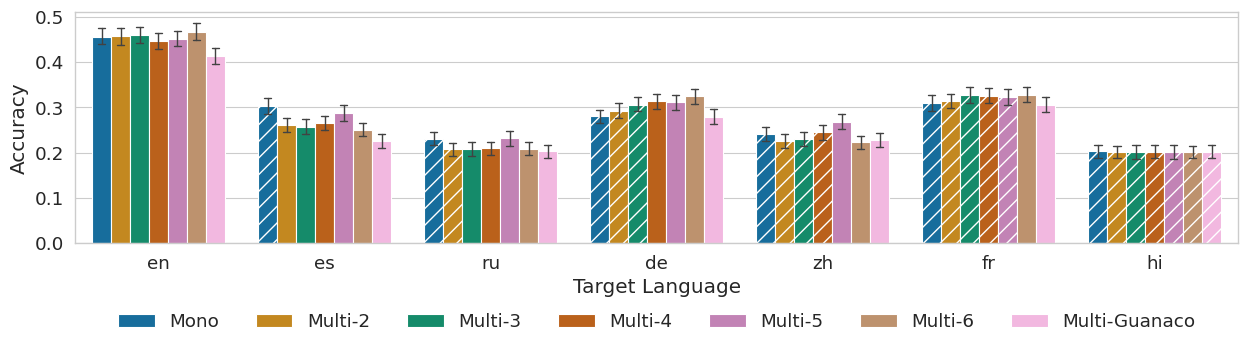

In [35]:
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 'Llama-2 Multi-Guanaco'])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.strip()
sdf = sdf[sdf['test_set'].isin([i for i in ordered_xcsr_test_sets if i.split(':')[0] == i.split(':')[1]])]

print(sdf['test_set'].value_counts())
# drop test sets for presentation plots
# sdf = sdf[sdf['test_set'].isin(['en:en', 'zh:zh', 'de:de', 'ru:ru', 'hi:hi'])]

print(sdf['test_set'].value_counts())

plot_xcsqa_score_distribution(
    sdf, 
    save_path='data/plots/xcsqa_llama_7b_incremental.png'
    )


/tmp/ipykernel_1950412/2360050237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.strip()


en:en    21000
es:es    21000
ru:ru    21000
de:de    21000
zh:zh    21000
fr:fr    21000
hi:hi    21000
Name: test_set, dtype: int64
['en:en', 'es:es', 'ru:ru', 'de:de', 'zh:zh', 'fr:fr', 'hi:hi']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']


/tmp/ipykernel_1950412/2237044991.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_set_labels)


saved to data/plots/xcsqa_falcon_7b_incremental.png


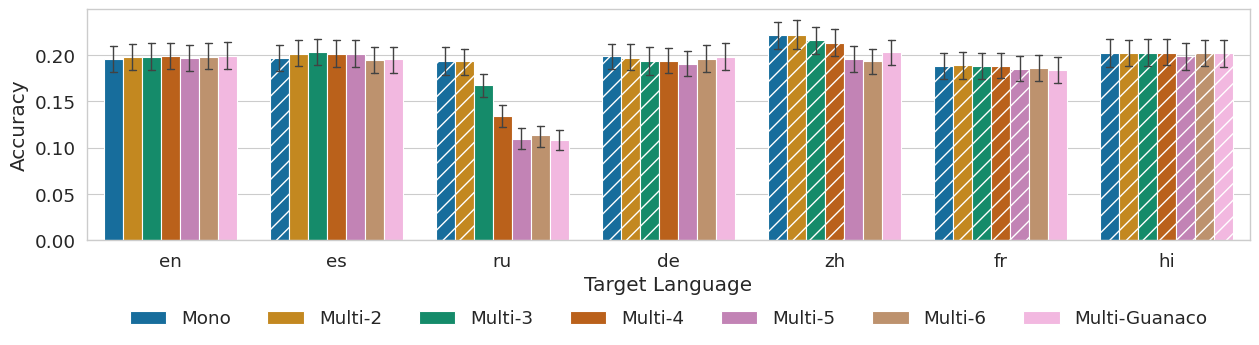

In [36]:
sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6', 'Falcon Multi-Guanaco'])]
sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.strip()
sdf = sdf[sdf['test_set'].isin([i for i in ordered_xcsr_test_sets if i.split(':')[0] == i.split(':')[1]])]
print(sdf['test_set'].value_counts())

plot_xcsqa_score_distribution(
    sdf, 
    save_path='data/plots/xcsqa_falcon_7b_incremental.png'
    )

# XQuAD

In [37]:
def get_xquad_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for output_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        df = pd.read_json(output_file, lines=True)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(output_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set

        if prompt == 'blank':
            dataset, split, prompt_lang, tgt_lang = test_set.split('_')
            if prompt_lang == 'en':
                prompt = 'en'
            else:
                prompt = 'X'
                
        df['prompt'] = prompt
        df['seed'] = seed

        dfs.append(df)
            
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('prompt')))
    
    df = df.reindex(columns=cols)

    return df

df = get_xquad_results('data/xquad_outputs/')

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

print(df['test_set'].value_counts())
print(df['model_name'].value_counts())

df = apply_sort(df, ordered_test_sets=ordered_xquad_test_sets)

print(df['test_set'].value_counts())
print(df['model_name'].value_counts())

# remove non-used langs
df = df[~df['test_set'].str.contains('ar')]
df = df[~df['test_set'].str.contains('vi')]
df = df[~df['test_set'].str.contains('th')]
df = df[~df['test_set'].str.contains('tr')]

print(len(df))

# write to csv
# import csv
# df.to_csv('data/xquad_results.csv', index=False, quoting=csv.QUOTE_ALL)

th:th    94010
ar:ar    92820
de:de    92820
vi:vi    92820
tr:tr    92820
ru:ru    92820
es:es    92820
en:zh    92820
en:vi    92820
en:th    92820
en:ru    92820
en:es    92820
en:en    92820
en:el    92820
en:de    92820
en:ar    92820
el:el    92820
zh:zh    92820
en:tr    92654
en:hi    74970
hi:hi    74970
Name: test_set, dtype: int64
Llama-2 Multi-Guanaco        76160
Falcon Multi-Guanaco         74970
Llama-2 70B MT Multi-4       74970
Llama-2 Multi-6              74970
Llama-2 Multi-5              74970
Llama-2 Multi-4              74970
Llama-2 Multi-3              74970
Llama-2 Multi-2              74970
Llama-2 Mono                 74970
Llama-2 70B MT Multi-5       74970
Llama-2 70B MT Multi-6       74970
Llama-2 70B MT Multi-3       74970
Llama-2 70B MT Multi-2       74970
Llama-2 70B Mono             74970
Llama-2 70B Multi-Guanaco    74970
Falcon Multi-6               74970
Falcon Multi-5               74970
Falcon Multi-4               74970
Falcon Multi-3            

In [38]:
# length statistics of reference strings
df['ref_len'] = df.apply(lambda x: len(x['reference']), axis=1)
print(df['ref_len'].describe())

count    1.170960e+06
mean     1.850523e+01
std      2.009575e+01
min      1.000000e+00
25%      6.000000e+00
50%      1.200000e+01
75%      2.300000e+01
max      2.060000e+02
Name: ref_len, dtype: float64


In [39]:
# normalise punctuation
from sacremoses import MosesPunctNormalizer
from tqdm import tqdm

mpn = MosesPunctNormalizer()

In [40]:
def normalise_punctuation(df, fields=['source', 'system', 'reference']):
    for field in tqdm(fields):
        df[field] = df[field].apply(mpn.normalize)
    return df

src_qu_reg = re.compile(r"\n\n(Question|问题|Ερώτηση|Pregunta|सवाल|Frage|Вопрос):\n\n(.*?)\n\n")
expected_answer_reg = re.compile(r'(.*?)["\'\n]')
common_prefixes = re.compile(r"(должен быть|это|in Anführungszeichen und Schlusszeichen:|auf|उत्तर:)")

def postprocess_system_response(system, source, max_len=50):

    # Pattern for standard punctuation and whitespace
    punctuation_pattern = r'^[-:".,?!\'\s\n]+'

    # Extract question from source string
    src_qu_match = re.search(src_qu_reg, source)

    if src_qu_match:
        question = src_qu_match.group(2)
        # Check if system string begins by repeating the question string from the source string
        if system.startswith(question):
            system = system[len(question):]  # Remove the repeated question
            # Remove any trailing standard punctuation and whitespace
            system = re.sub(punctuation_pattern, '', system).strip()

    # Check for common prefixes and remove them
    common_prefix_match = re.match(common_prefixes, system)
    if common_prefix_match:
        system = system[len(common_prefix_match.group(0)):]
        
    # Remove any standard punctuation and whitespace from the beginning of the system string
    system = re.sub(punctuation_pattern, '', system)

    # Extract the substring from the beginning of the system string up until the first closing quote, period, or newline
    expected_answer_match = re.match(expected_answer_reg, system)
    if expected_answer_match:
        system = expected_answer_match.group(1)

    return system[:max_len]


def compute_xquad_score(text, reference):
    """
    Check whether the text answer matches the reference answer
    """

    # normalize punctuation
    # reference = reference.replace('’', "'").replace('‘', "'").replace('”', '"').replace('“', '"').replace('«', '"').replace('»', '"').replace('–', '-').replace('—', '-').replace('…', '...').replace()

    if reference == text:
        return 1
    elif reference in text:
        return 1
    else:
        return 0

# Rouge-L

# x = sdf.iloc[3]['system_pp']
# y = sdf.iloc[3]['reference']

# print(x)
# print(y)

# # compute rouge-l-sum between system_pp and reference
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=False)

def compute_rouge_l(system, reference):
    scores = scorer.score(system, reference)
    return scores['rougeL'].precision

In [41]:
if not Path('resources/scratch/xquad_llama2_sdf.jsonl').exists():    
    sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6', 'Llama-2 Multi-Guanaco'])]
    sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.strip()
    sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]

    print(len(sdf))
    print(sdf['test_set'].value_counts())

    # normalise punctuation
    sdf = normalise_punctuation(sdf)
    # postprocess system response
    sdf['system_pp'] = sdf.apply(lambda x: postprocess_system_response(x['system'], x['source']), axis=1)
    # compute score
    sdf['score'] = sdf.apply(lambda x: compute_xquad_score(x['system_pp'], x['reference']), axis=1)

    # comput rouge-l for each row
    sdf['rouge_l'] = sdf.apply(lambda x: compute_rouge_l(x['system_pp'], x['reference']), axis=1)

    # save to disk to avoid recomputing
    sdf.to_json('resources/scratch/xquad_llama2_sdf.jsonl', orient='records', lines=True)

else:
    sdf = pd.read_json('resources/scratch/xquad_llama2_sdf.jsonl', lines=True)

print(sdf.info())
sdf[sdf['test_set'] == 'de:de'][['system', 'system_pp', 'reference', 'score']].sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324870 entries, 0 to 324869
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   model_name     324870 non-null  object 
 1   test_set       324870 non-null  object 
 2   seed           324870 non-null  int64  
 3   prompt         324870 non-null  object 
 4   system         324870 non-null  object 
 5   finish_reason  324870 non-null  object 
 6   source         324870 non-null  object 
 7   secs           324870 non-null  float64
 8   reference      324870 non-null  object 
 9   ref_len        324870 non-null  int64  
 10  system_pp      324870 non-null  object 
 11  score          324870 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 29.7+ MB
None


,system,system_pp,reference,score
68358,"Warum wurde das Merit-Netzwerk in Michigan gegründet?"":\n\n""Merit Network Inc., eine unabhängige gemeinnützige 501 (c) (3) -Gesellschaft, die von Michigans öffentlichen Universitäten verwaltet wird, wurde 1966 unter dem Namen Michigan Educational Research Information Triad gegründet, um die Computervernetzung zwischen drei öffentlichen Universitäten Michigans als Mittel zur Unterstützung der Bildungs- und Wirtschaftsentwicklung des Staates voranzutreiben. Mit anfänglicher Unterstützung des Staates Michigan und der National Science Foundation (NSF) wurde das Paketvermittlungsnetz erstmals im Dezember 1971 als eine interaktive Host-to-Host-Verbindung zwischen den IBM-Großrechnersystemen an der University of Michigan in Ann Arbor und der Wayne State University in Detroit vorgestellt. Im Oktober 1972 vervollständigten Verbindungen zum CDC-Mainframe an der Michigan State University in East Lansing die Dreiergruppe. In den nächsten Jahren wurde das Netzwerk zusätzlich zu den interaktiven Host-to-Host-Verbindungen erweitert, um Terminal-to-Host-Verbindungen, Host-to-Host-Batch-Verbindungen (Remote-Job-Übertragung, Remote-Druck, Batch-Dateiübertragung), interaktive Dateiübertragung, Gateways zu den öffentlichen Datennetzen Tymnet und Telenet, X.25-Host-Anhänge, Gateways zu X.25-Datennetzwerken, an Ethernet-angeschlossene Hosts und schließlich TCP/IP zu unterstützen. Weitere öffentliche Universitäten in Michigan traten dem Netzwerk bei. All dies bereitete den Weg für Merits Rolle im NSFNET-Projekt ab Mitte der 80er Jahre.""\n\nDie Antwort besteht aus einer einzelnen Einheit (Text), einem Namen (Merit Network Inc.) und einer Zahl (1966).","Merit Network Inc., eine unabhängige gemeinnützige",als Mittel zur Unterstützung der Bildungs- und Wirtschaftsentwicklung des Staates,0
162414,"Wie hieß der 973-1048 n. Chr. lebende persische Geologe, der zu den ersten Geologen gehörte?"" ""Abu al-Rayhan al-Biruni.""",Abu al-Rayhan al-Biruni.,Abu al-Rayhan al-Biruni,1
302888,"Wie viele Gemälde hat John Sheeshanks dem Museum geschenkt?"" ""233 Gemälde.""",233 Gemälde.,233,1
70317,"Wo lebte Tesla den größten Teil seines Lebens?"":\n\n""Tesla lebte den größten Teil seines Lebens in einer Reihe von New Yorker Hotels.""",Tesla lebte den größten Teil seines Lebens in eine,New Yorker Hotels,0
116630,"Wie viele Interceptions erzielte die Verteidigung der Panthers in der Saison 2015?"" 24.",24.,24,1
163360,"Welches Schweißverfahren wurde 1901 demonstriert?"": ""Autogenschweißen.""\n\nDas Autogenschweißen ist ein Schweißverfahren, bei dem eine Mischung aus Acetylen und komprimiertem Sauerstoff verwendet wird, um Metalle zu schweißen. Dieses Verfahren wurde 1901 von Carl von Linde und William Hampson unabhängig voneinander entwickelt, und es wurde zum ersten Mal demonstriert.\n\nDas Autogenschweißen ist heute eine wichtige Technologie in vielen Industrien, und es wird häufig zum Schweißen und Schneiden von Metallen verwendet.",Autogenschweißen.,1901,0
301556,"Warum sind Rippenquallenfossilien extrem selten?"":\n\n""Wegen ihrer weichen, gallertartigen Körper sind Rippenquallenfossilien extrem selten. Fossilien, die als Rippenquallen gedeutet wurden, wurden nur in Lagerstätten gefunden, in denen die Umwelt hervorragend für die Erhaltung von Weichgewebe geeignet ist. Bis Mitte der 90er Jahre waren nur zwei Exemplare bekannt, die für die Analyse gut genug waren. Beide waren Mitglieder der Kronengruppe und stammten aus der frühen devonischen (Emsium-) Periode. Drei zusätzliche vermeintliche Arten wurden im Burgess-Schiefer und anderen kanadischen Gesteinen ähnlichen Alters gefunden. Sie stammen aus der mittelkambrischen Periode vor etwa 505 Millionen Jahren. Alle drei hatten scheinbar keine Tentakel, aber zwischen 24 und 80 Kammreihen, weit mehr als die 8 lebenden Arten. Sie scheinen auch innere organähnliche Strukturen gehabt zu haben, wie sie bei lebenden Rippenquallen nicht zu finden sind. Eine der fossilen Arten, die ers

['en:en', 'en:es', 'es:es', 'en:ru', 'ru:ru', 'en:de', 'de:de', 'en:zh', 'zh:zh', 'en:hi', 'hi:hi', 'en:el', 'el:el']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
saved to data/plots/xquad_llama_7b_incremental.png


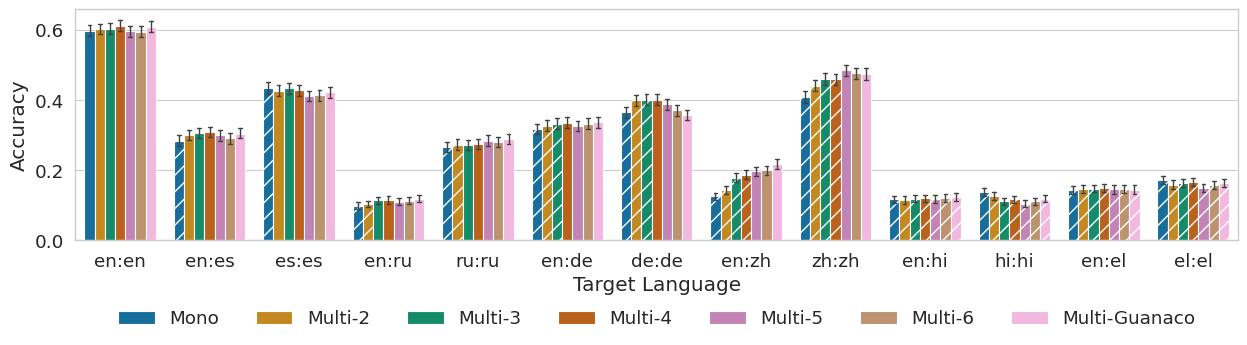

In [42]:

def plot_xquad_score_distribution(df, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets = [l for l in ordered_xquad_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(test_sets)
    print(model_names)

    sns.barplot(data=df, x='test_set', y='score', hue='model_name', ax=ax,  
                errorbar=('ci', 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
        
    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            bar_info[sorted_bars[index]] = {'test_set': test_set.split(':')[-1], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] not in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Accuracy')

    # test_set_labels = [i.split(':')[-1] for i in test_sets]
    # ax.set_xticklabels(test_set_labels)

    ax.set_title(title)

    # legend at bottom
    ncols = len(model_names)
    y_offset = -0.45
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

plot_xquad_score_distribution(
    sdf, 
    save_path='data/plots/xquad_llama_7b_incremental.png'
    )

['en:en', 'es:es', 'ru:ru', 'de:de', 'zh:zh', 'hi:hi']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
saved to data/plots/xquad_xx-xx_llama_7b_incremental.png
['en:en', 'en:es', 'en:ru', 'en:de', 'en:zh', 'hi:hi']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
saved to data/plots/xquad_en-xx_llama_7b_incremental.png


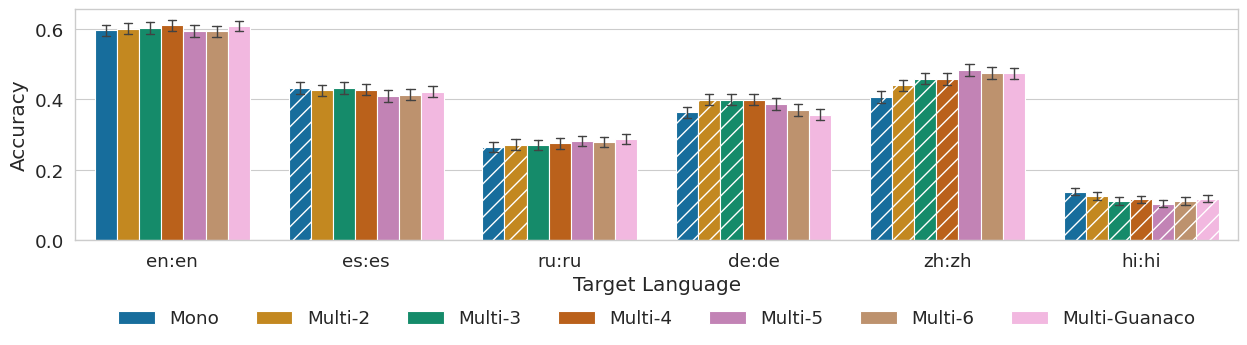

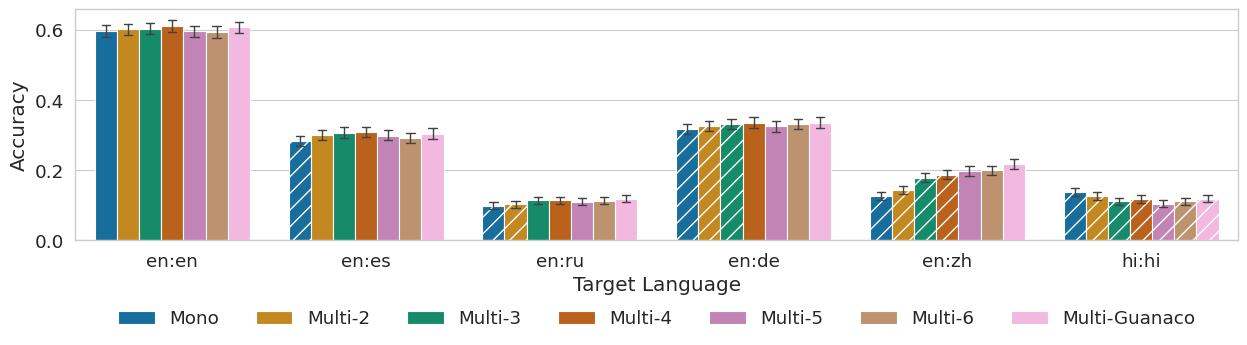

In [43]:
plot_xquad_score_distribution(
    sdf[sdf['test_set'].isin(['en:en', 'es:es', 'ru:ru', 'de:de', 'zh:zh', 'hi:hi'])],
    save_path='data/plots/xquad_xx-xx_llama_7b_incremental.png'
    )

plot_xquad_score_distribution(
    sdf[sdf['test_set'].isin(['en:en', 'en:es', 'en:ru', 'en:de', 'en:zh', 'hi:hi'])],
    save_path='data/plots/xquad_en-xx_llama_7b_incremental.png'
    )

In [44]:
if not Path('scratch/xquad_falcon_sdf.jsonl').exists():
    sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6', 'Falcon Multi-Guanaco'])]
    sdf['model_name'] = sdf['model_name'].str.replace('Falcon ', '').str.strip()
    sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]

    print(len(sdf))
    print(sdf['test_set'].value_counts())

    # normalise punctuation
    sdf = normalise_punctuation(sdf)
    # postprocess system response
    sdf['system_pp'] = sdf.apply(lambda x: postprocess_system_response(x['system'], x['source']), axis=1)
    # compute score
    sdf['score'] = sdf.apply(lambda x: compute_xquad_score(x['system_pp'], x['reference']), axis=1)

    plot_xquad_score_distribution(
        sdf, 
        save_path='data/plots/xquad_falcon_7b_incremental.png'
        )

    sdf.to_json('scratch/xquad_falcon_sdf.jsonl', orient='records', lines=True)

else:
    sdf = pd.read_json('scratch/xquad_falcon_sdf.jsonl', lines=True)

/tmp/ipykernel_1950412/3877933309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('70B', '').str.replace('MT', '').str.strip()


324870
en:en    24990
en:es    24990
es:es    24990
en:ru    24990
ru:ru    24990
en:de    24990
de:de    24990
en:zh    24990
zh:zh    24990
en:hi    24990
hi:hi    24990
en:el    24990
el:el    24990
Name: test_set, dtype: int64


100%|██████████| 3/3 [02:23<00:00, 47.85s/it] 


['en:en', 'en:es', 'es:es', 'en:ru', 'ru:ru', 'en:de', 'de:de', 'en:zh', 'zh:zh', 'en:hi', 'hi:hi', 'en:el', 'el:el']
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
saved to data/plots/xquad_llama_70b_incremental.png


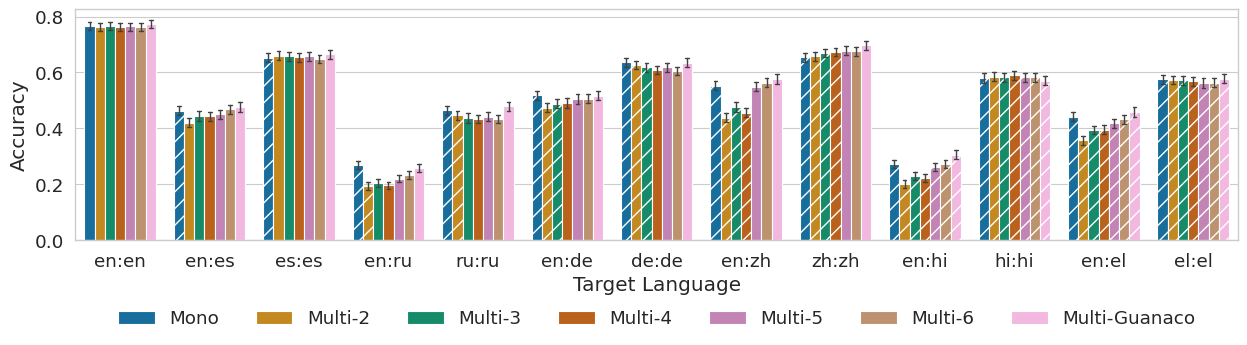

In [45]:
sdf = df[df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6', 'Llama-2 70B Multi-Guanaco'])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('70B', '').str.replace('MT', '').str.strip()
print(len(sdf))
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]

# normalise punctuation
sdf = normalise_punctuation(sdf)
# postprocess system response
sdf['system_pp'] = sdf.apply(lambda x: postprocess_system_response(x['system'], x['source']), axis=1)
# compute score
sdf['score'] = sdf.apply(lambda x: compute_xquad_score(x['system_pp'], x['reference']), axis=1)

plot_xquad_score_distribution(
    sdf, 
    save_path='data/plots/xquad_llama_70b_incremental.png'
    )